In [90]:
import os
import sys
import gzip
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from Bio.Seq import Seq
import matplotlib as mpl
import json
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [23]:
# 从训练脚本导入必要的函数和类
# 定义配置和必要的函数
@dataclass
class Config:
    outdir: str
    tsv: str
    seq_len: int = 4096
    batch_size: int = 64
    num_workers: int = 4
    cache_dir: str = ""
    max_cache_bp: int = 200_000

VOCAB = {"A": 1, "C": 2, "G": 3, "T": 4, "N": 5}  # 0 PAD

def read_first_fasta_sequence_gz(path: str) -> str:
    seq_lines = []
    with gzip.open(path, "rt") as f:
        for line in f:
            if line.startswith(">"):
                if seq_lines:
                    break
                continue
            seq_lines.append(line.strip())
    return "".join(seq_lines).upper()

def encode_full_seq_to_uint8(seq: str) -> np.ndarray:
    arr = np.zeros(len(seq), dtype=np.uint8)
    for i, ch in enumerate(seq):
        arr[i] = VOCAB.get(ch, 5)
    return arr

def build_genome_path(outdir: str, taxid: str, asm: str, db_source: str) -> str:
    base = "refseq" if db_source == "refseq" else "genbank"
    return os.path.join(outdir, base, "downloads", taxid, asm, f"{asm}_genomic.fna.gz")


In [24]:
# 数据集类（简化版，用于加载和可视化）
class ViralFamilyFullSeqDataset:
    def __init__(self, df: pd.DataFrame, cfg: Config, label2id: dict):
        self.df = df.reset_index(drop=True)
        self.cfg = cfg
        self.label2id = label2id
        self.cache_dir = cfg.cache_dir
        if self.cache_dir:
            os.makedirs(self.cache_dir, exist_ok=True)

    def __len__(self):
        return len(self.df)

    def _cache_path(self, asm: str) -> str:
        return os.path.join(self.cache_dir, f"{asm}.npy")

    def __getitem__(self, idx: int):
        r = self.df.iloc[idx]
        taxid = str(r["taxid"])
        asm = str(r["asm"])
        db = str(r["db_source"])
        y = self.label2id[str(r["family"])]

        # 1) load from cache if exists
        if self.cache_dir:
            cp = self._cache_path(asm)
            if os.path.exists(cp):
                x_full = np.load(cp, mmap_mode=None)  # uint8
                return x_full, int(y)

        # 2) load fasta.gz and encode full
        fna = build_genome_path(self.cfg.outdir, taxid, asm, db)
        if not os.path.exists(fna):
            x_full = np.zeros(0, dtype=np.uint8)
        else:
            seq = read_first_fasta_sequence_gz(fna)
            x_full = encode_full_seq_to_uint8(seq)

        # 3) optionally cache
        if self.cache_dir:
            if self.cfg.max_cache_bp <= 0 or len(x_full) <= self.cfg.max_cache_bp:
                np.save(self._cache_path(asm), x_full)

        return x_full, int(y)


In [25]:
# 配置路径（根据实际情况修改）
# 如果环境变量已设置，使用环境变量；否则使用默认路径
OUTDIR = os.environ.get("OUTDIR", "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/ncbi_viral")
TSV = os.environ.get("TSV", os.path.join(OUTDIR, "merged", "rep.family_top100.tsv"))

# 检查是否存在已生成的 split 文件
split_dir = os.path.join(OUTDIR, "merged", "splits_genus_disjoint")
use_existing_splits = os.path.exists(os.path.join(split_dir, "train.tsv"))

print(f"OUTDIR: {OUTDIR}")
print(f"TSV: {TSV}")
print(f"使用已存在的 split 文件: {use_existing_splits}")

OUTDIR: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/ncbi_viral
TSV: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/ncbi_viral/merged/rep.family_top100.tsv
使用已存在的 split 文件: True


In [26]:
# 加载数据
if use_existing_splits:
    # 使用已存在的 split 文件
    train_df = pd.read_csv(os.path.join(split_dir, "train.tsv"), sep="\t")
    val_df = pd.read_csv(os.path.join(split_dir, "val.tsv"), sep="\t")
    test_df = pd.read_csv(os.path.join(split_dir, "test.tsv"), sep="\t")
    print(f"从 split 文件加载: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")
else:
    # 从原始 TSV 加载（需要重新 split）
    from sklearn.model_selection import GroupShuffleSplit
    
    def make_group_key(df: pd.DataFrame) -> pd.Series:
        g = df["genus"].astype(str).fillna("")
        bad = g.isna() | (g.str.strip() == "") | (g.str.upper() == "NA") | (g.str.upper() == "NAN") | (g == "-")
        key = g.copy()
        key[bad] = "taxid_" + df.loc[bad, "taxid"].astype(str)
        return key
    
    def group_split_2way(df: pd.DataFrame, groups: pd.Series, test_size: float, seed: int):
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
        idx_a, idx_b = next(gss.split(df, groups=groups))
        return df.iloc[idx_a].copy(), df.iloc[idx_b].copy()
    
    df = pd.read_csv(TSV, sep="\t")
    df["group_key"] = make_group_key(df)
    
    train_all, test_df = group_split_2way(df, df["group_key"], test_size=0.10, seed=42)
    train_df, val_df = group_split_2way(train_all, train_all["group_key"], test_size=0.10, seed=43)
    
    # 确保类别在训练集中存在
    fam_train = set(train_df["family"].astype(str).unique())
    train_df = train_df[train_df["family"].astype(str).isin(fam_train)].copy()
    val_df = val_df[val_df["family"].astype(str).isin(fam_train)].copy()
    test_df = test_df[test_df["family"].astype(str).isin(fam_train)].copy()
    
    print(f"重新 split: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

# 创建 label2id 映射
families = sorted(train_df["family"].astype(str).unique())
label2id = {f: i for i, f in enumerate(families)}
id2label = {i: f for f, i in label2id.items()}

print(f"\n数据集统计:")
print(f"  训练集: {len(train_df)} 样本")
print(f"  验证集: {len(val_df)} 样本")
print(f"  测试集: {len(test_df)} 样本")
print(f"  类别数: {len(families)}")


从 split 文件加载: train=13261, val=2348, test=1933

数据集统计:
  训练集: 13261 样本
  验证集: 2348 样本
  测试集: 1933 样本
  类别数: 100


Total dataset size: 17542 samples

Loading sequence lengths for all 17542 samples...


Loading sequences:   0%|          | 0/17542 [00:00<?, ?it/s]

Loading sequences: 100%|██████████| 17542/17542 [15:46<00:00, 18.53it/s] 



Sequence Length Statistics (based on 17542 samples):
  Min length: 165 bp
  Max length: 1,991,922 bp
  Mean length: 39,876 bp
  Median length: 9,206 bp
  Std deviation: 73,247 bp


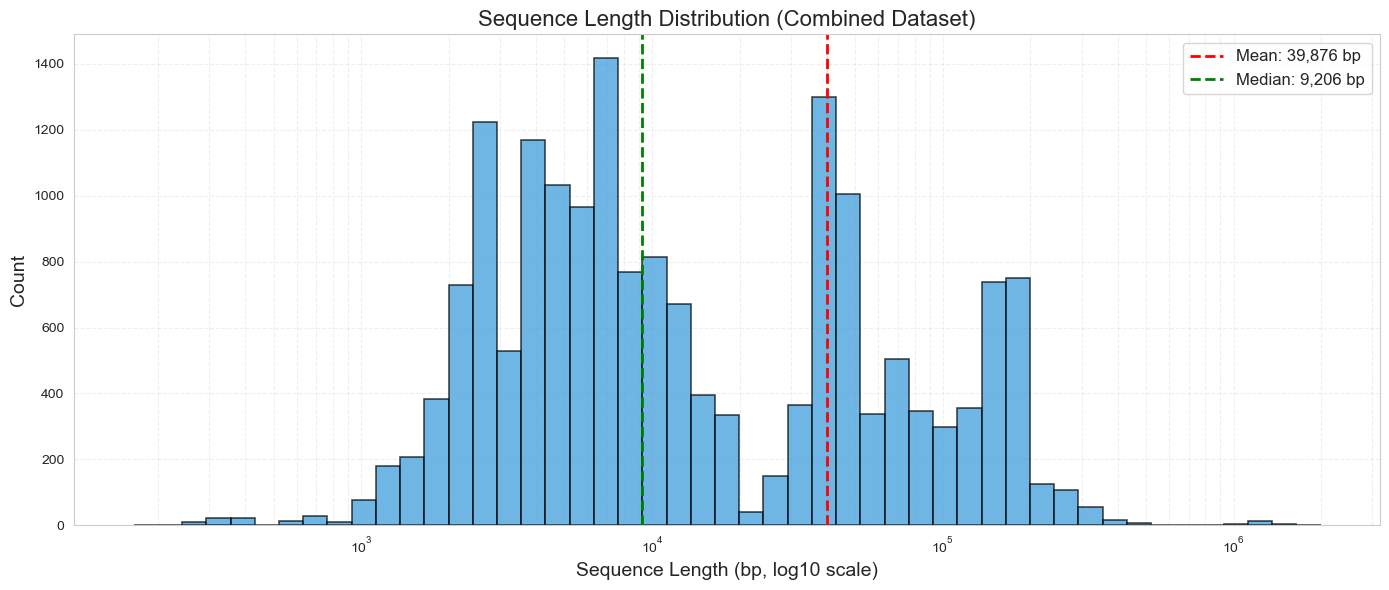

In [27]:
# Visualization: Sequence Length Distribution (Combined Dataset)
# Merge train, val, and test datasets
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(f"Total dataset size: {len(all_df)} samples")

# Configure paths
cfg = Config(
    outdir=OUTDIR,
    tsv=TSV,
    cache_dir=os.path.join(OUTDIR, "merged", "cache_fullseq_uint8_top100")
)

# Create dataset for all samples
all_ds = ViralFamilyFullSeqDataset(all_df, cfg, label2id)

# Load all sequence lengths
print(f"\nLoading sequence lengths for all {len(all_ds)} samples...")
seq_lengths = []
for idx in tqdm(range(len(all_ds)), desc="Loading sequences"):
    try:
        x_full, y = all_ds[idx]
        seq_lengths.append(len(x_full))
    except Exception as e:
        print(f"Warning: Failed to load index {idx}: {e}")
        continue

seq_lengths = np.array(seq_lengths)
print(f"\nSequence Length Statistics (based on {len(seq_lengths)} samples):")
print(f"  Min length: {seq_lengths.min():,} bp")
print(f"  Max length: {seq_lengths.max():,} bp")
print(f"  Mean length: {seq_lengths.mean():,.0f} bp")
print(f"  Median length: {np.median(seq_lengths):,.0f} bp")
print(f"  Std deviation: {seq_lengths.std():,.0f} bp")

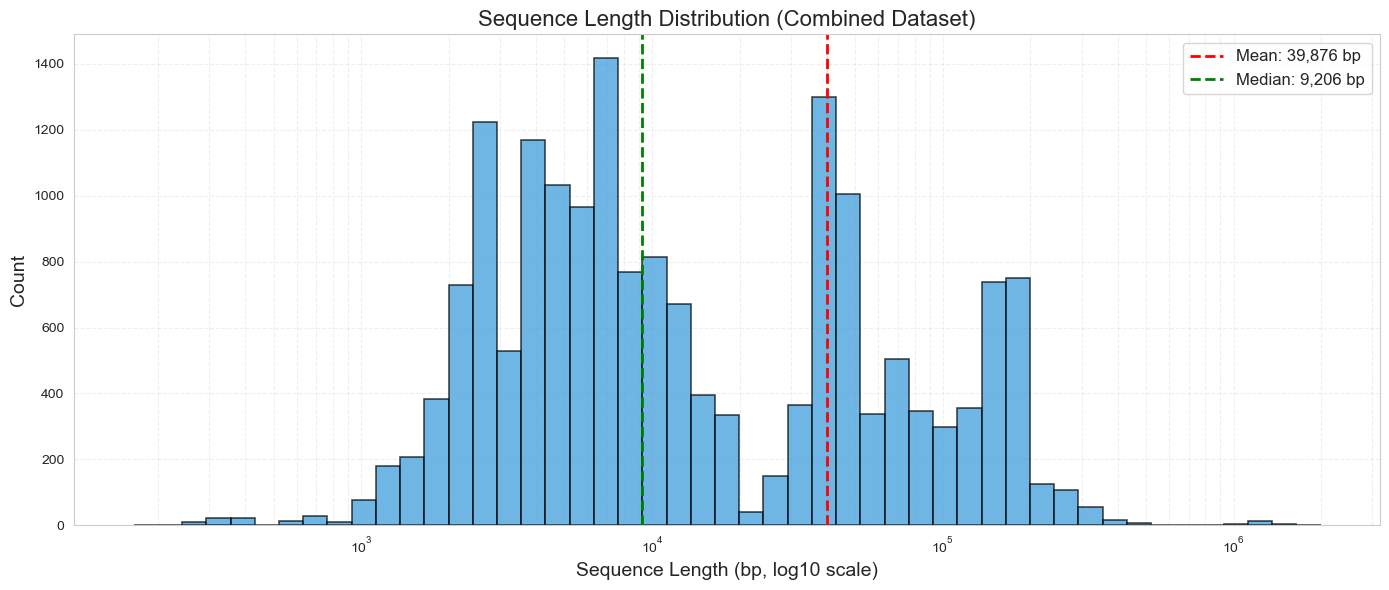

In [ ]:
# Plot histogram: x-axis = length (log10 scale), y-axis = count
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# 设置边框为黑色
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# Use log-spaced bins for better visualization with log scale
log_min = np.log10(seq_lengths[seq_lengths > 0].min())
log_max = np.log10(seq_lengths.max())
log_bins = np.logspace(log_min, log_max, 50)

ax.hist(seq_lengths, bins=log_bins, color='#3498db', alpha=0.7, edgecolor='black', linewidth=1.2)
ax.set_xscale('log')  # Set x-axis to log10 scale
ax.set_xlabel('Sequence Length (bp, log10 scale)', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Sequence Length Distribution (Combined Dataset)', fontsize=16)
ax.grid(alpha=0.3, linestyle='--', which='both')  # Show grid for both major and minor ticks

# Add mean and median lines
mean_val = seq_lengths.mean()
median_val = np.median(seq_lengths)
ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:,.0f} bp')
ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:,.0f} bp')
ax.legend(fontsize=12)

# # Add text box with statistics
# textstr = f'Total samples: {len(seq_lengths):,}\nMin: {seq_lengths.min():,} bp\nMax: {seq_lengths.max():,} bp'
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# ax.text(0.98, 0.98, textstr, transform=ax.transAxes, fontsize=11,
#         verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

In [29]:
# 读取文件
tsv_file_path = "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/ncbi_viral/merged/rep.family_top100.with_header.with_host.with_group.corrected.cleaned_host.tsv"

# 使用 pandas 读取 TSV 文件
df = pd.read_csv(tsv_file_path, sep="\t")

# 过滤数据：排除 host_group 为 "UNK" 或 "OTHER" 的行
df_filtered = df[(df['host_group_changed'] != "UNK") & (df['host_group_changed'] != "OTHER")]

# 或者使用更简洁的方式：
# df_filtered = df[~df['host_group'].isin(["UNK", "OTHER"])]

print(f"原始数据: {len(df)} 行")
print(f"过滤后数据: {len(df_filtered)} 行")
print(f"\nhost_group 值分布:")
print(df['host_group'].value_counts())

原始数据: 5789 行
过滤后数据: 5789 行

host_group 值分布:
host_group
A     2971
D3     589
E      547
B      543
C      450
D1     368
D2     321
Name: count, dtype: int64


In [30]:
# 统计每个 host_group 包含多少个不同的 host_name
host_group_host_count = df_filtered.groupby('host_group_fixed')['host_name_clean'].nunique().sort_values(ascending=False)

# 准备输出文件路径
output_dir = os.path.dirname(tsv_file_path)
txt_output_path = os.path.join(output_dir, "host_group_host_name_statistics.txt")

# 使用 StringIO 收集所有输出内容
from io import StringIO
output_buffer = StringIO()

# 定义一个函数，同时输出到控制台和缓冲区
def print_both(*args, **kwargs):
    print(*args, **kwargs)  # 输出到控制台
    print(*args, file=output_buffer, **kwargs)  # 输出到缓冲区

print_both("每个 host_group 包含的不同 host_name 数量:")
print_both("=" * 50)
# 将 pandas Series 转换为字符串以便写入文件
host_count_str = str(host_group_host_count)
print(host_count_str)  # 控制台输出
output_buffer.write(host_count_str + "\n")  # 文件输出
print_both("\n" + "=" * 50)
print_both(f"总计: {len(df_filtered)} 行数据")
print_both(f"不同的 host_group 数量: {len(host_group_host_count)}")
print_both(f"不同的 host_name 总数: {df_filtered['host_name_clean'].nunique()}")

# 更详细的统计：显示每个 host_group 的具体 host_name 列表
print_both("\n" + "=" * 50)
print_both("每个 host_group 的 host_name 详情:")
print_both("=" * 50)
for host_group in host_group_host_count.index:
    # 获取当前 host_group 的数据
    group_df = df_filtered[df_filtered['host_group_fixed'] == host_group]
    host_names = group_df['host_name_clean'].unique()
    # 过滤掉空值
    host_names = [h for h in host_names if pd.notna(h) and str(h).strip() != '']
    sorted_host_names = sorted(host_names)
    
    # 统计每个 host_name 在当前 host_group 中的出现次数
    host_name_counts_in_group = group_df[group_df['host_name_clean'].notna() & (group_df['host_name_clean'].str.strip() != '')]['host_name_clean'].value_counts()
    
    # 计算该 host_group 的总行数
    group_total_count = len(group_df)
    
    # 控制台输出：如果太多则省略
    print(f"\n{host_group} ({len(host_names)} 个不同的 host_name):")
    if len(host_names) <= 20:
        for i, hn in enumerate(sorted_host_names, 1):
            count = host_name_counts_in_group.get(hn, 0)
            print(f"  {i}. {hn} ({count} 次)")
    else:
        # 如果太多，只显示前10个和后10个
        for i, hn in enumerate(sorted_host_names[:10], 1):
            count = host_name_counts_in_group.get(hn, 0)
            print(f"  {i}. {hn} ({count} 次)")
        print(f"  ... (还有 {len(host_names) - 20} 个)")
        for i, hn in enumerate(sorted_host_names[-10:], len(host_names) - 9):
            count = host_name_counts_in_group.get(hn, 0)
            print(f"  {i}. {hn} ({count} 次)")
    print(f"  总计: {group_total_count} 行")
    
    # 文件输出：显示完整的列表，不省略，包含出现次数
    output_buffer.write(f"\n{host_group} ({len(host_names)} 个不同的 host_name):\n")
    for i, hn in enumerate(sorted_host_names, 1):
        count = host_name_counts_in_group.get(hn, 0)
        output_buffer.write(f"  {i}. {hn} ({count} 次)\n")
    output_buffer.write(f"  总计: {group_total_count} 行\n")

# 统计每个 host_name 的出现次数
print_both("\n\n" + "=" * 50)
print_both("每个 host_name 的出现次数统计:")
print_both("=" * 50)

# 统计每个 host_name_clean 的出现次数（排除空值）
host_name_counts = df_filtered[df_filtered['host_name_clean'].notna() & (df_filtered['host_name_clean'].str.strip() != '')]['host_name_clean'].value_counts().sort_values(ascending=False)

host_count_str = str(host_name_counts)
print(host_count_str)  # 控制台输出
output_buffer.write("\n\n" + "=" * 50 + "\n")
output_buffer.write("每个 host_name 的出现次数统计:\n")
output_buffer.write("=" * 50 + "\n")
output_buffer.write(host_count_str + "\n")

print_both(f"\n总计: {len(df_filtered)} 行数据")
print_both(f"不同的 host_name 总数: {len(host_name_counts)}")
print_both(f"host_name 出现次数总和: {host_name_counts.sum()}")

# 显示每个 host_name 的详细统计（写入文件，控制台显示前20个）
print_both("\n" + "=" * 50)
print_both("每个 host_name 的详细统计:")
print_both("=" * 50)

# 控制台输出：只显示前20个
print("\n前20个出现次数最多的 host_name:")
for i, (host_name, count) in enumerate(host_name_counts.head(20).items(), 1):
    print(f"  {i}. {host_name}: {count} 次")

# 文件输出：显示完整的统计
output_buffer.write("\n" + "=" * 50 + "\n")
output_buffer.write("每个 host_name 的详细统计:\n")
output_buffer.write("=" * 50 + "\n")
for i, (host_name, count) in enumerate(host_name_counts.items(), 1):
    output_buffer.write(f"  {i}. {host_name}: {count} 次\n")

# 将缓冲区内容写入文件
with open(txt_output_path, 'w', encoding='utf-8') as f:
    f.write(output_buffer.getvalue())

print_both(f"\n\n统计结果已保存到文件:")
print_both(f"  {txt_output_path}")

每个 host_group 包含的不同 host_name 数量:
host_group_fixed
E     143
D3     99
C      74
A      33
B      32
D2     32
D1      7
Name: host_name_clean, dtype: int64

总计: 5789 行数据
不同的 host_group 数量: 7
不同的 host_name 总数: 419

每个 host_group 的 host_name 详情:

E (143 个不同的 host_name):
  1. Aedes aegypti (3 次)
  2. Aedes albopictus (10 次)
  3. Aedes campestris (1 次)
  4. Aedes cumminsii (1 次)
  5. Aedes curtipes (1 次)
  6. Aedes dorsalis (1 次)
  7. Aedes fulvus (1 次)
  8. Aedes japonicus (1 次)
  9. Aedes normanensis (1 次)
  10. Aedes opok (1 次)
  ... (还有 123 个)
  134. blue swimmer crab (1 次)
  135. fiddler crab (1 次)
  136. freshwater atyid shrimp (1 次)
  137. hard ticks (1 次)
  138. hermit Crab (1 次)
  139. hermit crab (2 次)
  140. insect (5 次)
  141. oyster mushroom (1 次)
  142. sand fly (2 次)
  143. sandfly (6 次)
  总计: 547 行

D3 (99 个不同的 host_name):
  1. Amblyomma variegatum/Hipposideros jonesi (1 次)
  2. Aselliscus stoliczkanus (1 次)
  3. Bat (Chiroptera) (25 次)
  4. Cardioderma cor (1 次)
  5. Cerv

In [31]:
# 保存过滤后的数据为 TSV 文件（添加 clean 后缀）
# 获取原文件路径和目录
output_dir = os.path.dirname(tsv_file_path)
original_filename = os.path.basename(tsv_file_path)
# 在文件名中添加 .clean 后缀（在 .tsv 之前）
if original_filename.endswith('.tsv'):
    clean_filename = original_filename.replace('.tsv', '.clean.tsv')
else:
    clean_filename = original_filename + '.clean.tsv'

output_path = os.path.join(output_dir, clean_filename)

# 保存为 TSV 文件
df_filtered.to_csv(output_path, sep='\t', index=False)

print(f"已保存过滤后的数据到:")
print(f"  {output_path}")
print(f"  数据行数: {len(df_filtered)}")
print(f"  数据列数: {len(df_filtered.columns)}")
print(f"\n列名: {', '.join(df_filtered.columns.tolist())}")


已保存过滤后的数据到:
  /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/ncbi_viral/merged/rep.family_top100.with_header.with_host.with_group.corrected.cleaned_host.clean.tsv
  数据行数: 5789
  数据列数: 28

列名: taxid, ftp_path, asm, organism_name, source, family, genus, species, db_source, extra_0, extra_1, extra_2, extra_3, extra_4, extra_5, extra_6, host_name, host_name_raw, lab_host_name, isolation_source, gbff_path, host_group, host_group_raw, expected_group, expected2, host_group_fixed, host_group_changed, host_name_clean


Train: 13261 samples, length range: 165 - 1,991,922 bp
Val: 2348 samples, length range: 229 - 351,909 bp
Test: 1933 samples, length range: 292 - 1,573,504 bp

合并数据集统计:
  总样本数: 17,542
  平均长度: 39,876 bp
  中位数长度: 9,206 bp

图表已保存为: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img/genome_cls_length_distribution.png
图表已保存为: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img/genome_cls_length_distribution.pdf


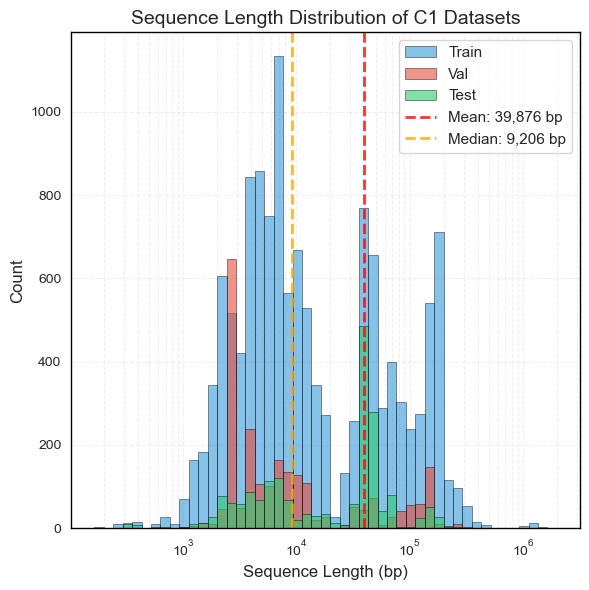

In [91]:
# 可视化 Genome_cls 三个数据集的长度分布
import os

# 读取三个数据集
data_dir = "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/genome_cls"
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
val_df = pd.read_csv(os.path.join(data_dir, "val.csv"))
test_df = pd.read_csv(os.path.join(data_dir, "test.csv"))

# 计算每个数据集的序列长度
train_lengths = train_df['sequence'].str.len().values
val_lengths = val_df['sequence'].str.len().values
test_lengths = test_df['sequence'].str.len().values

print(f"Train: {len(train_lengths)} samples, length range: {train_lengths.min():,} - {train_lengths.max():,} bp")
print(f"Val: {len(val_lengths)} samples, length range: {val_lengths.min():,} - {val_lengths.max():,} bp")
print(f"Test: {len(test_lengths)} samples, length range: {test_lengths.min():,} - {test_lengths.max():,} bp")

# 绘制长度分布图（方形图）
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# 设置边框为黑色
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# 使用直方图，设置 density=True 显示频率
bins = np.logspace(np.log10(min(train_lengths.min(), val_lengths.min(), test_lengths.min())), 
                   np.log10(max(train_lengths.max(), val_lengths.max(), test_lengths.max())), 
                   50)

ax.hist(train_lengths, bins=bins, alpha=0.6, label='Train', color='#3498db', density=False, 
        edgecolor='black', linewidth=0.5, weights=None)
ax.hist(val_lengths, bins=bins, alpha=0.6, label='Val', color='#e74c3c', density=False, 
        edgecolor='black', linewidth=0.5, weights=None)
ax.hist(test_lengths, bins=bins, alpha=0.6, label='Test', color='#2ecc71', density=False, 
        edgecolor='black', linewidth=0.5, weights=None)

# 合并三个数据集的长度，计算平均长度和中位数
all_lengths = np.concatenate([train_lengths, val_lengths, test_lengths])
mean_length = np.mean(all_lengths)
median_length = np.median(all_lengths)

print(f"\n合并数据集统计:")
print(f"  总样本数: {len(all_lengths):,}")
print(f"  平均长度: {mean_length:,.0f} bp")
print(f"  中位数长度: {median_length:,.0f} bp")

ax.set_xscale('log')
ax.set_xlabel('Sequence Length (bp)', fontsize=12, weight='normal')
ax.set_ylabel('Count', fontsize=12, weight='normal')
ax.set_title('Sequence Length Distribution of C1 Datasets', fontsize=14, weight='normal')
ax.legend(fontsize=11, frameon=True, fancybox=True, shadow=False)
ax.grid(True, alpha=0.3, linestyle='--', which='both')

# 添加平均长度和中位数线
ax.axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_length:,.0f} bp', alpha=0.8)
ax.axvline(median_length, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_length:,.0f} bp', alpha=0.8)

# 更新图例以包含平均长度和中位数线
ax.legend(fontsize=11, frameon=True, fancybox=True, shadow=False)

# 设置所有文本元素不加粗
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_weight('normal')

plt.tight_layout()

# 保存为330dpi的透明PNG图和PDF
save_dir = "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img"
os.makedirs(save_dir, exist_ok=True)
save_path_png = os.path.join(save_dir, "genome_cls_length_distribution.png")
save_path_pdf = os.path.join(save_dir, "genome_cls_length_distribution.pdf")
plt.savefig(save_path_png, dpi=330, transparent=True, bbox_inches='tight')
plt.savefig(save_path_pdf, transparent=True, bbox_inches='tight')
print(f"\n图表已保存为: {save_path_png}")
print(f"图表已保存为: {save_path_pdf}")

plt.show()

请你帮我可视化一下/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/data/C2_data.csv数据集的长度分布
数据集的示例如下
idx,taxid,organism_name,family,genus,species,host_name,host_group
0,10566,Human papillomavirus,Papillomaviridae,nan,Human papillomavirus,Homo sapiens,D1
1,10571,Bovine papillomavirus,Papillomaviridae,nan,Bovine papillomavirus,Bos taurus,D2
其中 host_group 为分组，有A、B、C、D1、D2、D3、E
请你帮我绘制CDS长度的平均值，其中横坐标为A、B、C、D1、D2、D3、E
纵坐标为CDS的长度，CDS来自文件/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/data/C2_data_cds.json
每行有多个CDS

数据读取成功。
Group           Sample_Count    Avg_CDS_Len (bp)    
-------------------------------------------------------
A (Bacteria)    8185            2964.98
B (Fungi/Plants) 636             2673.08
C (Plants)      1095            1726.53
D1 (Human/Primate) 971             2227.92
D2 (Livestock)  774             2471.91
D3 (Wildlife)   1478            2639.00
E (Invertebrates) 1294            3253.63

图表已保存为: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img/cds_length_distribution_by_host_group.png
图表已保存为: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img/cds_length_distribution_by_host_group.pdf

===== Longest CDS (Global) =====
Length (bp): 23697
idx: 2597
host_group: E (Invertebrates)
header_info: {'sequence_id': 'lcl|MZ209617.1_cds_UHK03264.1_1', 'locus_tag': 'FuFV1_gp1', 'protein': 'polyprotein', 'protein_id': 'UHK03264.1', 'location': '89..23785', 'gbkey': 'CDS'}
Longest CDS saved to: longest_cds.fasta


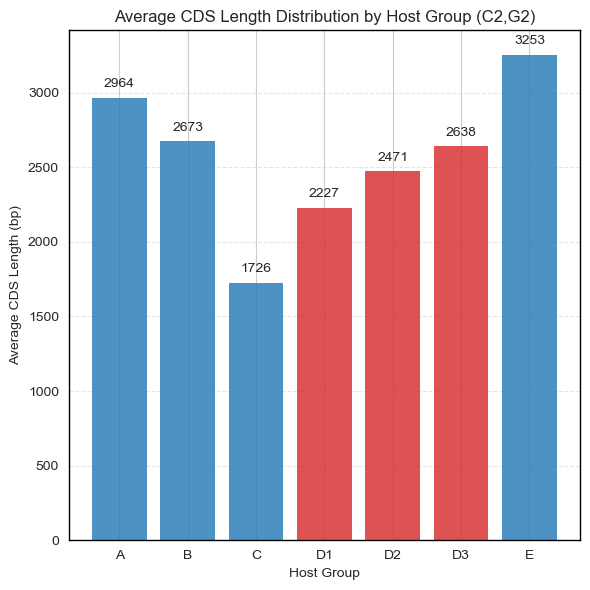

In [92]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

# 1. 设置文件路径
csv_path = '/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/data/C2_data.csv'
json_path = '/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/data/C2_data_cds.json'

# 2. 读取数据
try:
    df = pd.read_csv(csv_path)
    with open(json_path, 'r') as f:
        cds_data = json.load(f)
    print("数据读取成功。")
except Exception as e:
    print(f"读取错误: {e}")
    raise SystemExit(1)

# 3. 定义函数：过滤不合法的CDS
def is_valid_cds(seq: str) -> bool:
    """
    检查CDS序列是否合法
    
    检查项：
    1. 是否以起始密码子（ATG）开头
    2. 是否以终止密码子（TAA, TAG, TGA）结尾
    3. 长度是否是3的倍数
    4. 序列中间是否存在提前的终止密码子（不包括最后一个）
    
    Args:
        seq: CDS序列字符串（大写）
    
    Returns:
        bool: 如果CDS合法返回True，否则返回False
    """
    if not seq:
        return False
    
    seq = seq.upper().strip()
    
    # 检查1: 长度是否是3的倍数
    if len(seq) % 3 != 0:
        return False
    
    # 检查2: 是否以起始密码子（ATG）开头
    if not seq.startswith('ATG'):
        return False
    
    # 检查3: 是否以终止密码子（TAA, TAG, TGA）结尾
    stop_codons = ['TAA', 'TAG', 'TGA']
    if not seq.endswith(tuple(stop_codons)):
        return False
    
    # 检查4: 序列中间是否存在提前的终止密码子（不包括最后一个）
    # 从位置3开始，每3个碱基检查一次，直到倒数第3个（最后一个密码子）
    for i in range(3, len(seq) - 3, 3):
        codon = seq[i:i+3]
        if codon in stop_codons:
            return False
    
    return True

def filter_valid_cds(cds_list: list) -> list:
    """
    过滤CDS列表，只保留合法的CDS
    
    Args:
        cds_list: CDS字典列表，每个字典应包含'sequence'字段
    
    Returns:
        list: 过滤后的合法CDS列表
    """
    valid_cds_list = []
    for cds in cds_list:
        seq = cds.get('sequence', '')
        if seq and is_valid_cds(seq):
            valid_cds_list.append(cds)
    return valid_cds_list

# 4. 初始化分组统计
# 映射 host_group 到其中文含义（可选，用于理解）
group_map = {
    'A': 'Bacteria',
    'B': 'Fungi/Plants',  # 你备注里提到 B/C 都可能含植物相关，这里保持你的 label
    'C': 'Plants',
    'D1': 'Human/Primate',
    'D2': 'Livestock',
    'D3': 'Wildlife',
    'E': 'Invertebrates'
}
target_groups = ['A', 'B', 'C', 'D1', 'D2', 'D3', 'E']
group_lengths = {g: [] for g in target_groups}

# ✅ 新增：全局最长 CDS 记录
max_len = 0
max_seq = None
max_idx = None
max_group = None
max_header = None
top=3

# 5. 遍历数据
for _, row in df.iterrows():
    idx = str(row['idx'])
    group = row['host_group']

    if group in group_lengths and idx in cds_data:
        cds_list = cds_data[idx]
        
        # 过滤不合法的CDS
        valid_cds_list = filter_valid_cds(cds_list)
        
        # 按照长度排序（从长到短）
        valid_cds_list = sorted(valid_cds_list, key=lambda x: len(x.get('sequence', '')), reverse=True)
        valid_cds_list = valid_cds_list[:top]
        for cds in valid_cds_list:
            seq = cds.get('sequence', '')
            if not seq:
                continue

            L = len(seq)
            group_lengths[group].append(L)

            # ✅ 更新全局最长 CDS
            if L > max_len:
                max_len = L
                max_seq = seq
                max_idx = idx
                max_group = group
                # 兼容不同字段名
                max_header = cds.get('header_info', cds.get('header', cds.get('id', None)))

# 6. 计算平均值和样本数
means = []
counts = []
stds = []

print(f"{'Group':<15} {'Sample_Count':<15} {'Avg_CDS_Len (bp)':<20}")
print("-" * 55)

for g in target_groups:
    lens = group_lengths[g]
    if lens:
        avg = np.mean(lens)
        std = np.std(lens)
        count = len(lens)  # 注意：这是CDS的数量，不是物种/病毒数量
    else:
        avg = 0
        std = 0
        count = 0

    means.append(avg)
    stds.append(std)
    counts.append(count)
    print(f"{g + ' (' + group_map.get(g, '') + ')':<15} {count:<15} {avg:.2f}")

# 7. 绘图（方形图）
plt.figure(figsize=(6, 6))
ax = plt.gca()

# 设置边框为黑色
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

bars = plt.bar(
    target_groups,
    means,
    color=['#d62728' if 'D' in x else '#1f77b4' for x in target_groups],
    alpha=0.8,
    edgecolor='none'
)

plt.xlabel('Host Group')
plt.ylabel('Average CDS Length (bp)')
plt.title('Average CDS Length Distribution by Host Group (C2,G2)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 在柱子上标记数值
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 50,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

plt.tight_layout()

# 保存为330dpi的透明PNG图和PDF
save_dir = "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img"
os.makedirs(save_dir, exist_ok=True)
save_path_png = os.path.join(save_dir, "cds_length_distribution_by_host_group.png")
save_path_pdf = os.path.join(save_dir, "cds_length_distribution_by_host_group.pdf")
plt.savefig(save_path_png, dpi=330, transparent=True, bbox_inches='tight')
plt.savefig(save_path_pdf, transparent=True, bbox_inches='tight')
print(f"\n图表已保存为: {save_path_png}")
print(f"图表已保存为: {save_path_pdf}")

# 8. ✅ 输出全局最长 CDS（长度 + 来源信息）
if max_seq is not None:
    print("\n===== Longest CDS (Global) =====")
    print(f"Length (bp): {max_len}")
    print(f"idx: {max_idx}")
    print(f"host_group: {max_group} ({group_map.get(max_group, '')})")
    print(f"header_info: {max_header}")

    # 可选：保存为 fasta，避免终端输出超长序列
    out_fa = "longest_cds.fasta"
    with open(out_fa, "w") as f:
        f.write(f">idx={max_idx}|group={max_group}|len={max_len}\n")
        for i in range(0, len(max_seq), 60):
            f.write(max_seq[i:i+60] + "\n")
    print(f"Longest CDS saved to: {out_fa}")
else:
    print("\n未找到任何 CDS 序列（请检查 idx 是否匹配、json 字段名是否为 'sequence'）。")



图表已保存为 cds_length_hist_all.png


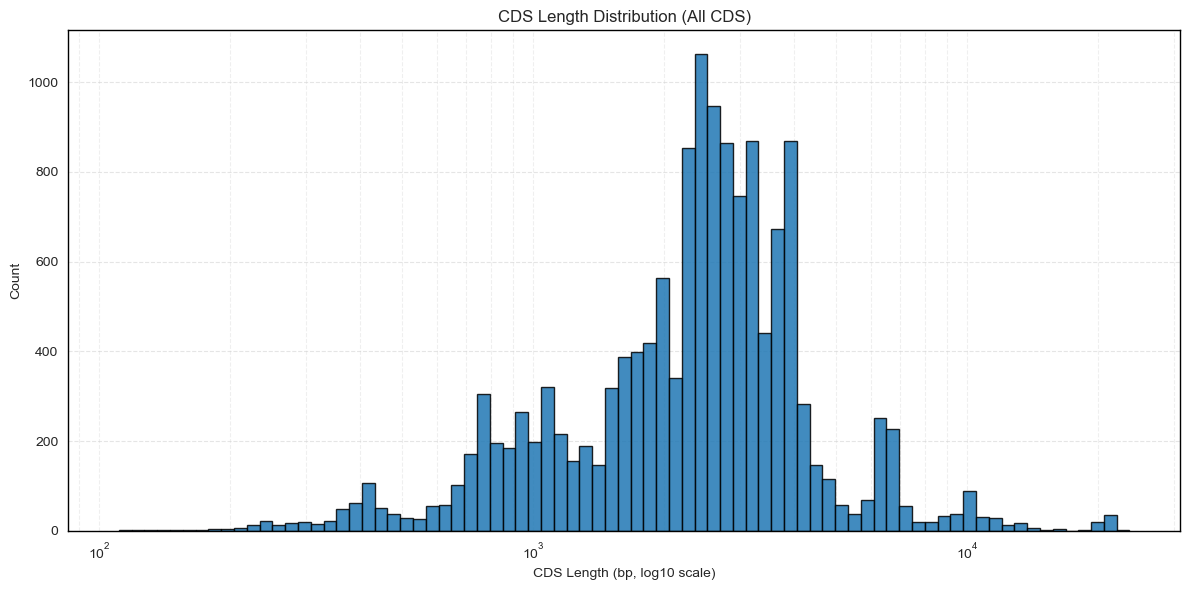

In [74]:
# 6. 绘图：横坐标 CDS 长度，纵坐标 个数（所有 CDS 合并）
all_lens = []
for g in target_groups:
    all_lens.extend(group_lengths[g])

plt.figure(figsize=(12, 6))
ax = plt.gca()

# 设置边框为黑色
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

if len(all_lens) == 0:
    print("没有可用于绘图的 CDS 长度数据。")
else:
    # 使用 log10 间距的 bins
    log_min = np.log10(min(all_lens))
    log_max = np.log10(max(all_lens))
    bins = np.logspace(log_min, log_max, 80)
    
    plt.hist(all_lens, bins=bins, alpha=0.85, edgecolor='black')
    plt.xscale('log')  # 设置 x 轴为对数刻度

    plt.xlabel('CDS Length (bp, log10 scale)')
    plt.ylabel('Count')
    plt.title('CDS Length Distribution (All CDS)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.grid(axis='x', linestyle='--', alpha=0.3, which='both')  # 添加 x 轴网格

    plt.tight_layout()
    out_png = 'cds_length_hist_all.png'
    plt.savefig(out_png, dpi=200)
    print(f"\n图表已保存为 {out_png}")



图表已保存为 cds_length_hist_by_group.png


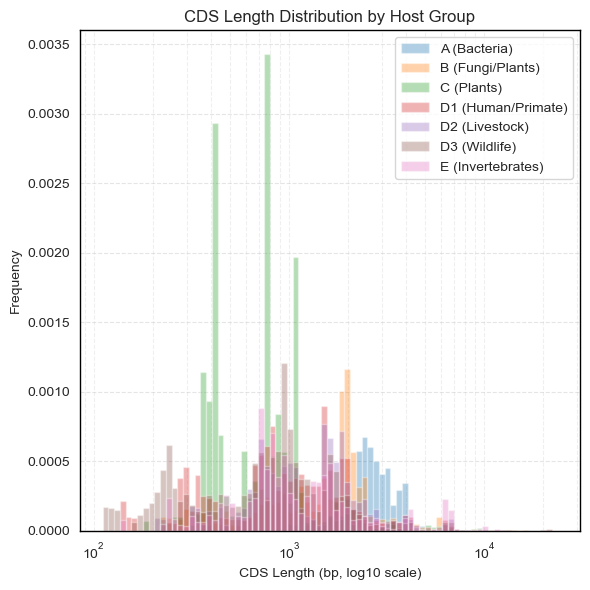

In [75]:
# 6. 绘图：同一张图叠加不同 host_group 的长度分布
plt.figure(figsize=(6, 6))
ax = plt.gca()

# 设置边框为黑色
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# 统一 bins（保证不同组可比）
all_lens = [L for g in target_groups for L in group_lengths[g]]
if len(all_lens) == 0:
    print("没有可用于绘图的 CDS 长度数据。")
else:
    # 使用 log10 间距的 bins
    log_min = np.log10(min(all_lens))
    log_max = np.log10(max(all_lens))
    bins = np.logspace(log_min, log_max, 80)

    for g in target_groups:
        lens = group_lengths[g]

        if len(lens) == 0:
            continue
        plt.hist(lens, bins=bins, alpha=0.35, label=f"{g} ({group_map.get(g,'')})", density=True)

    plt.xscale('log')  # 设置 x 轴为对数刻度
    plt.xlabel('CDS Length (bp, log10 scale)')
    plt.ylabel('Frequency')
    plt.title('CDS Length Distribution by Host Group')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.grid(axis='x', linestyle='--', alpha=0.3, which='both')  # 添加 x 轴网格
    plt.legend()

    plt.tight_layout()
    out_png = 'cds_length_hist_by_group.png'
    plt.savefig(out_png, dpi=200)
    print(f"\n图表已保存为 {out_png}")


In [94]:
data=pd.read_csv("/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/data/G1_data.csv")
data

,idx,taxid,organism_name,family,genus,species,sequence
0,1,10291,unidentified entomopoxvirus,Poxviridae,NaN,unidentified entomopoxvirus,GTACGTATATTAATCATGATTGGATAAATATATTTGAAAAAATTGA...
1,4,10535,unidentified adenovirus,Adenoviridae,Mastadenovirus,unidentified adenovirus,CAATCAAAATTGATACCGCATGTTCGGGAGCTAAAATCTGCTCGAG...
2,5,10561,Xipapillomavirus 1,Papillomaviridae,Xipapillomavirus,Xipapillomavirus 1,ATGTTATTACTTGCACCCGATTCGGTCGCACCGTTTGAGGTACATA...
3,6,10564,Deltapapillomavirus 2,Papillomaviridae,Deltapapillomavirus,Deltapapillomavirus 2,GTTAACAATAACCAGACCTTAGCCGTTTTTGGGTGAGCGGGAAAGA...
4,7,10565,Alces alces papillomavirus 1,Papillomaviridae,Deltapapillomavirus,Deltapapillomavirus 1,GTTAACAATCACCAGATCTTGCCCGTTTTTGTGAGCGGGAAAGCTG...
...,...,...,...,...,...,...,...
15596,17536,3433855,Papaya mosaic virus,Alphaflexiviridae,Potexvirus,Potexvirus papayae,GAAAAGAAACACAAAGCAAAGCAAAGCAAAGCAACTCAAATAAACC...
15597,17537,3433856,Pepino mosaic virus,Alphaflexiviridae,Potexvirus,Potexvirus pepini,GAAAACAAAATAAATAAATAAATATACAAAGTTAAACTAACACAAC...
15598,17538,3433857,Foxtail mosaic virus,Alphaflexiviridae,Potexvirus,Potexvirus setariae,GAAAACTCTTCCGAAACCGAAACTGACTGAAACTACCTCGACCGAC...
15599,17539,3433858,Asparagus virus 3,Alphaflexiviridae,Potexvirus,Potexvirus triasparagi,GGAAAACAAAACAACACAGAAACACTCGCAACTTAACTGCCCATAT...


In [95]:
len(data["sequence"].to_list()[0])

1686

In [96]:
model_name_list=["evo2_1b_base","evo2_7b_base","evo2_7b","evo2_40b_base","evo2_40b"]
ppl_path=[]
for model_name in model_name_list:
    ppl_path.append("/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/conditional_ppl_"+model_name+".csv")
ppl_data=[]
for i,path in enumerate(ppl_path):
    ppl_data.append(pd.read_csv(path))
    data["ppl_"+model_name_list[i]]=ppl_data[i]["ppl"]

In [97]:
data

,idx,taxid,organism_name,family,genus,species,sequence,ppl_evo2_1b_base,ppl_evo2_7b_base,ppl_evo2_7b,ppl_evo2_40b_base,ppl_evo2_40b
0,1,10291,unidentified entomopoxvirus,Poxviridae,NaN,unidentified entomopoxvirus,GTACGTATATTAATCATGATTGGATAAATATATTTGAAAAAATTGA...,2.977890,2.921404,2.930335,2.921849,2.914802
1,4,10535,unidentified adenovirus,Adenoviridae,Mastadenovirus,unidentified adenovirus,CAATCAAAATTGATACCGCATGTTCGGGAGCTAAAATCTGCTCGAG...,3.666829,4.293530,3.487934,3.725578,3.475727
2,5,10561,Xipapillomavirus 1,Papillomaviridae,Xipapillomavirus,Xipapillomavirus 1,ATGTTATTACTTGCACCCGATTCGGTCGCACCGTTTGAGGTACATA...,3.652743,3.643313,3.650713,3.629521,3.633289
3,6,10564,Deltapapillomavirus 2,Papillomaviridae,Deltapapillomavirus,Deltapapillomavirus 2,GTTAACAATAACCAGACCTTAGCCGTTTTTGGGTGAGCGGGAAAGA...,3.788213,3.776240,3.781162,3.774927,3.771404
4,7,10565,Alces alces papillomavirus 1,Papillomaviridae,Deltapapillomavirus,Deltapapillomavirus 1,GTTAACAATCACCAGATCTTGCCCGTTTTTGTGAGCGGGAAAGCTG...,3.777564,3.759147,3.769996,3.753022,3.756643
...,...,...,...,...,...,...,...,...,...,...,...,...
15596,17536,3433855,Papaya mosaic virus,Alphaflexiviridae,Potexvirus,Potexvirus papayae,GAAAAGAAACACAAAGCAAAGCAAAGCAAAGCAACTCAAATAAACC...,3.738506,3.683360,3.685572,3.691854,3.689708
15597,17537,3433856,Pepino mosaic virus,Alphaflexiviridae,Potexvirus,Potexvirus pepini,GAAAACAAAATAAATAAATAAATATACAAAGTTAAACTAACACAAC...,3.619822,3.586932,3.596321,3.591252,3.592080
15598,17538,3433857,Foxtail mosaic virus,Alphaflexiviridae,Potexvirus,Potexvirus setariae,GAAAACTCTTCCGAAACCGAAACTGACTGAAACTACCTCGACCGAC...,3.755761,3.709183,3.722181,3.710313,3.720032
15599,17539,3433858,Asparagus virus 3,Alphaflexiviridae,Potexvirus,Potexvirus triasparagi,GGAAAACAAAACAACACAGAAACACTCGCAACTTAACTGCCCATAT...,3.765713,3.726776,3.736668,3.723684,3.732688


In [47]:
# 在此可视化，其中data为要可视化的DataFrame类型的对象，其中包含列idx	taxid	organism_name	family	genus	species	sequence	ppl_evo2_1b_base	ppl_evo2_7b_base	ppl_evo2_7b	ppl_evo2_40b_base	ppl_evo2_40b
# 其中横坐标为序列长度len(sequence)，纵坐标为ppl的值，每个模型绘制折线图


图表已保存为: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img/perplexity_vs_sequence_length.png
图表已保存为: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img/perplexity_vs_sequence_length.pdf


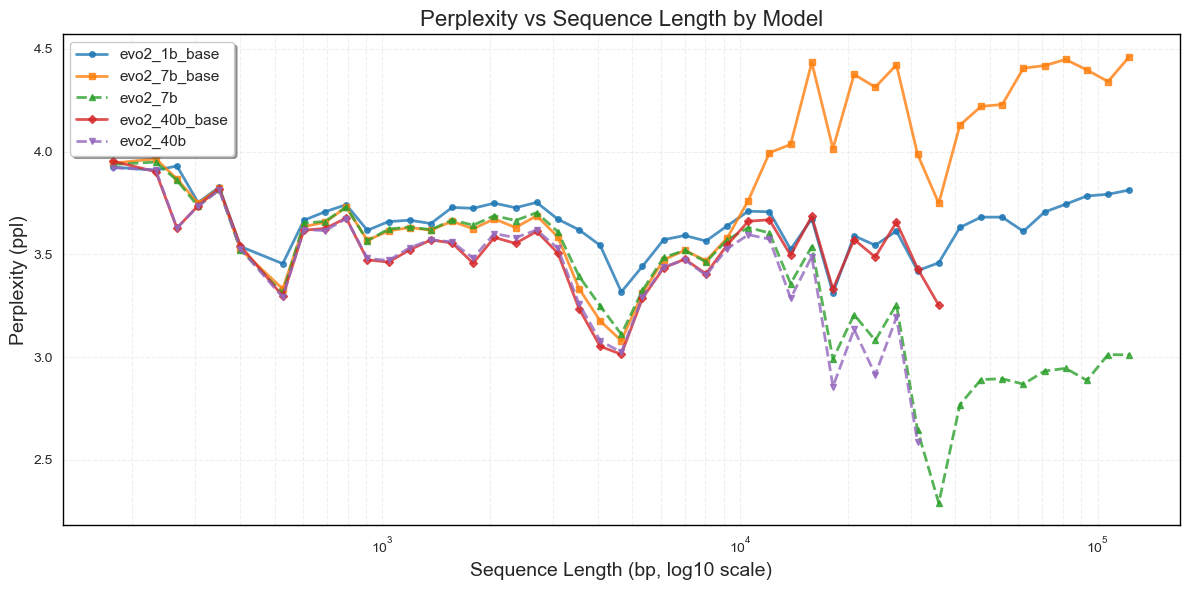


序列长度统计:
  最小长度: 165 bp
  最大长度: 130,952 bp
  平均长度: 21,104 bp
  中位数长度: 7,382 bp

各模型的平均Perplexity:
  evo2_1b_base: 3.6165
  evo2_7b_base: 3.7533
  evo2_7b: 3.2904
  evo2_40b_base: 3.4311
  evo2_40b: 3.3870


In [98]:
# 计算序列长度
data['seq_length'] = data['sequence'].str.len()

# 模型列名
model_columns = ['ppl_evo2_1b_base', 'ppl_evo2_7b_base', 'ppl_evo2_7b', 'ppl_evo2_40b_base', 'ppl_evo2_40b']
model_labels = ['evo2_1b_base', 'evo2_7b_base', 'evo2_7b', 'evo2_40b_base', 'evo2_40b']

# 创建图形
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# 设置边框为黑色
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# 定义颜色和样式
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
linestyles = ['-', '-', '--', '-', '--']
markers = ['o', 's', '^', 'D', 'v']

# 方法1: 使用分箱（binning）来平滑数据
# 创建对数分箱
min_len = data['seq_length'].min()
max_len = data['seq_length'].max()
num_bins = 50
log_bins = np.logspace(np.log10(max(min_len, 1)), np.log10(max_len), num_bins)

# 为每个数据点分配bin
data['length_bin'] = pd.cut(data['seq_length'], bins=log_bins, labels=False, include_lowest=True)

# 计算每个bin的中心点和平均值
bin_centers = []
bin_means = {col: [] for col in model_columns}

for i in range(len(log_bins) - 1):
    bin_data = data[data['length_bin'] == i]
    if len(bin_data) > 0:
        bin_center = (log_bins[i] + log_bins[i+1]) / 2
        bin_centers.append(bin_center)
        for col in model_columns:
            # 只计算非NaN值的平均值
            valid_ppl = bin_data[col].dropna()
            if len(valid_ppl) > 0:
                bin_means[col].append(valid_ppl.mean())
            else:
                bin_means[col].append(np.nan)

# 绘制每个模型的折线图
for idx, (col, label) in enumerate(zip(model_columns, model_labels)):
    if col in data.columns:
        # 过滤掉NaN值
        valid_indices = ~np.isnan(bin_means[col])
        if np.any(valid_indices):
            ax.plot(np.array(bin_centers)[valid_indices], 
                   np.array(bin_means[col])[valid_indices],
                   color=colors[idx], 
                   linestyle=linestyles[idx],
                   marker=markers[idx],
                   markersize=4,
                   linewidth=2,
                   label=label,
                   alpha=0.8)

ax.set_xscale('log')
ax.set_xlabel('Sequence Length (bp, log10 scale)', fontsize=14)
ax.set_ylabel('Perplexity (ppl)', fontsize=14)
ax.set_title('Perplexity vs Sequence Length by Model', fontsize=16)
ax.legend(fontsize=11, frameon=True, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--', which='both')

# 绘制竖线 x=8192
# ax.axvline(x=8192, color='black', linestyle=':', linewidth=2, alpha=0.7)
# ax.axvline(x=4096, color='black', linestyle=':', linewidth=2, alpha=0.7)

plt.tight_layout()

# 保存为330dpi的透明PNG图和PDF
save_dir = "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img"
os.makedirs(save_dir, exist_ok=True)
save_path_png = os.path.join(save_dir, "perplexity_vs_sequence_length.png")
save_path_pdf = os.path.join(save_dir, "perplexity_vs_sequence_length.pdf")
plt.savefig(save_path_png, dpi=330, transparent=True, bbox_inches='tight')
plt.savefig(save_path_pdf, transparent=True, bbox_inches='tight')
print(f"\n图表已保存为: {save_path_png}")
print(f"图表已保存为: {save_path_pdf}")

plt.show()

# 打印统计信息
print("\n序列长度统计:")
print(f"  最小长度: {data['seq_length'].min():,} bp")
print(f"  最大长度: {data['seq_length'].max():,} bp")
print(f"  平均长度: {data['seq_length'].mean():,.0f} bp")
print(f"  中位数长度: {data['seq_length'].median():,.0f} bp")

print("\n各模型的平均Perplexity:")
for col, label in zip(model_columns, model_labels):
    if col in data.columns:
        avg_ppl = data[col].mean()
        print(f"  {label}: {avg_ppl:.4f}")


Top 20 families (按数据量排序):
  1. Microviridae: 1078 个样本
  2. Geminiviridae: 700 个样本
  3. Autotranscriptaviridae: 664 个样本
  4. Rhabdoviridae: 595 个样本
  5. Steitzviridae: 466 个样本

图表已保存为: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img/perplexity_distribution_by_family.png
图表已保存为: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img/perplexity_distribution_by_family.pdf


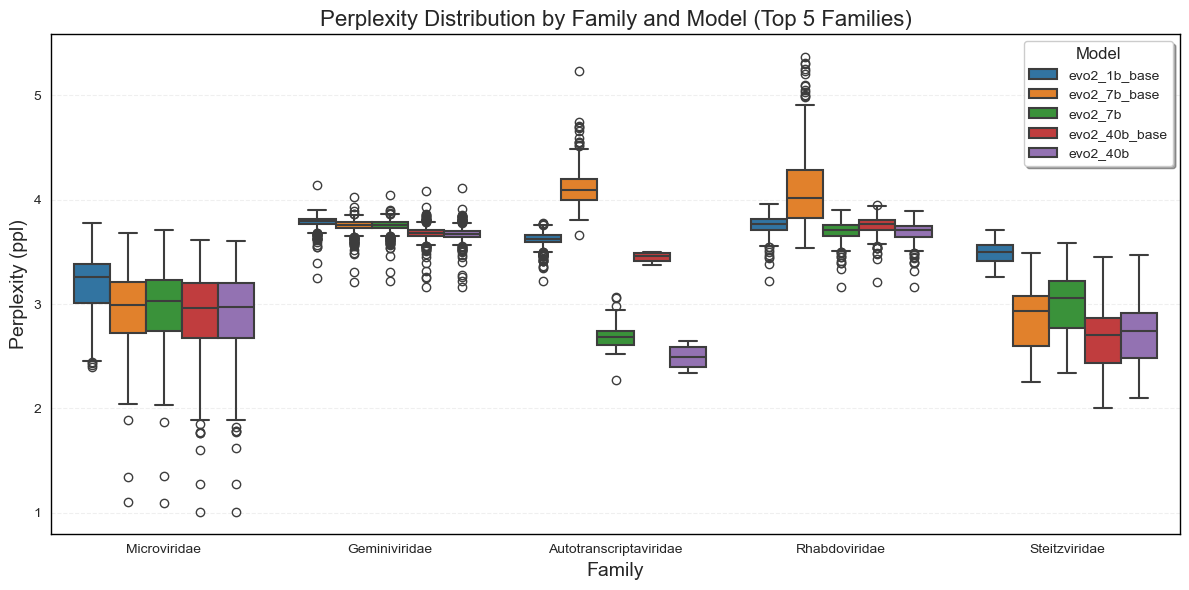


各 Family 的样本数统计 (Top 20):

Microviridae:
  evo2_1b_base: 样本数=1078, 平均ppl=3.1863, 中位数ppl=3.2628
  evo2_7b_base: 样本数=1078, 平均ppl=2.9466, 中位数ppl=2.9959
  evo2_7b: 样本数=1078, 平均ppl=2.9653, 中位数ppl=3.0247
  evo2_40b_base: 样本数=1078, 平均ppl=2.9045, 中位数ppl=2.9616
  evo2_40b: 样本数=1078, 平均ppl=2.9077, 中位数ppl=2.9679

Geminiviridae:
  evo2_1b_base: 样本数=700, 平均ppl=3.7871, 中位数ppl=3.7945
  evo2_7b_base: 样本数=700, 平均ppl=3.7509, 中位数ppl=3.7603
  evo2_7b: 样本数=700, 平均ppl=3.7513, 中位数ppl=3.7577
  evo2_40b_base: 样本数=700, 平均ppl=3.6749, 中位数ppl=3.6766
  evo2_40b: 样本数=700, 平均ppl=3.6701, 中位数ppl=3.6721

Autotranscriptaviridae:
  evo2_1b_base: 样本数=664, 平均ppl=3.6198, 中位数ppl=3.6222
  evo2_7b_base: 样本数=664, 平均ppl=4.1061, 中位数ppl=4.0909
  evo2_7b: 样本数=664, 平均ppl=2.6808, 中位数ppl=2.6805
  evo2_40b_base: 样本数=4, 平均ppl=3.4479, 中位数ppl=3.4570
  evo2_40b: 样本数=4, 平均ppl=2.4929, 中位数ppl=2.4956

Rhabdoviridae:
  evo2_1b_base: 样本数=595, 平均ppl=3.7563, 中位数ppl=3.7676
  evo2_7b_base: 样本数=595, 平均ppl=4.0956, 中位数ppl=4.0144
  evo2_7b: 样本数=595, 平均p

In [99]:
# 绘制分组箱线图：横坐标为 top 20 的 family，纵坐标为 ppl，每个 family 对应五个模型的箱体

# 1. 找到 top 20 的 family（按个数排序）
family_counts = data['family'].value_counts()
top20_families = family_counts.head(5).index.tolist()

print(f"Top 20 families (按数据量排序):")
for i, fam in enumerate(top20_families, 1):
    count = family_counts[fam]
    print(f"  {i}. {fam}: {count} 个样本")

# 2. 过滤数据，只保留 top 20 的 family
data_top20 = data[data['family'].isin(top20_families)].copy()

# 3. 准备数据用于箱线图
# 需要将数据重塑为长格式：family, model, ppl
model_columns = ['ppl_evo2_1b_base', 'ppl_evo2_7b_base', 'ppl_evo2_7b', 'ppl_evo2_40b_base', 'ppl_evo2_40b']
model_labels = ['evo2_1b_base', 'evo2_7b_base', 'evo2_7b', 'evo2_40b_base', 'evo2_40b']

# 创建长格式数据
plot_data = []
for _, row in data_top20.iterrows():
    family = row['family']
    for col, label in zip(model_columns, model_labels):
        if col in row and pd.notna(row[col]):
            plot_data.append({
                'family': family,
                'model': label,
                'ppl': row[col]
            })

plot_df = pd.DataFrame(plot_data)

# 4. 确保 family 的顺序按照数据量排序
plot_df['family'] = pd.Categorical(plot_df['family'], categories=top20_families, ordered=True)

# 5. 绘制分组箱线图
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# 设置边框为黑色
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# 使用 seaborn 绘制分组箱线图
import seaborn as sns

# 设置颜色
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
model_palette = {label: color for label, color in zip(model_labels, colors)}

# 绘制箱线图
box_plot = sns.boxplot(
    data=plot_df,
    x='family',
    y='ppl',
    hue='model',
    palette=model_palette,
    ax=ax,
    width=0.8,
    linewidth=1.5
)

ax.set_xlabel('Family', fontsize=14)
ax.set_ylabel('Perplexity (ppl)', fontsize=14)
ax.set_title('Perplexity Distribution by Family and Model (Top 5 Families)', fontsize=16)
ax.legend(title='Model', fontsize=10, title_fontsize=12, frameon=True, fancybox=True, shadow=True)

# 旋转 x 轴标签以便更好地显示
# plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# 添加网格
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()

# 保存为330dpi的透明PNG图和PDF
save_dir = "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img"
os.makedirs(save_dir, exist_ok=True)
save_path_png = os.path.join(save_dir, "perplexity_distribution_by_family.png")
save_path_pdf = os.path.join(save_dir, "perplexity_distribution_by_family.pdf")
plt.savefig(save_path_png, dpi=330, transparent=True, bbox_inches='tight')
plt.savefig(save_path_pdf, transparent=True, bbox_inches='tight')
print(f"\n图表已保存为: {save_path_png}")
print(f"图表已保存为: {save_path_pdf}")

plt.show()

# 打印统计信息
print("\n各 Family 的样本数统计 (Top 20):")
for fam in top20_families:
    fam_data = plot_df[plot_df['family'] == fam]
    print(f"\n{fam}:")
    for model in model_labels:
        model_data = fam_data[fam_data['model'] == model]['ppl']
        if len(model_data) > 0:
            print(f"  {model}: 样本数={len(model_data)}, 平均ppl={model_data.mean():.4f}, 中位数ppl={model_data.median():.4f}")


Total number of families: 99

Top 5 families (sorted by evo2_40b_base average ppl, smallest to largest):
  1. Retroviridae: avg_ppl=2.4947, sample_count=104
  2. Inoviridae: avg_ppl=2.5427, sample_count=226
  3. Steitzviridae: avg_ppl=2.6643, sample_count=466
  4. Microviridae: avg_ppl=2.9045, sample_count=1078
  5. Andersonviridae: avg_ppl=2.9096, sample_count=206

图表已保存为: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img/perplexity_distribution_by_family_sorted.png
图表已保存为: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img/perplexity_distribution_by_family_sorted.pdf


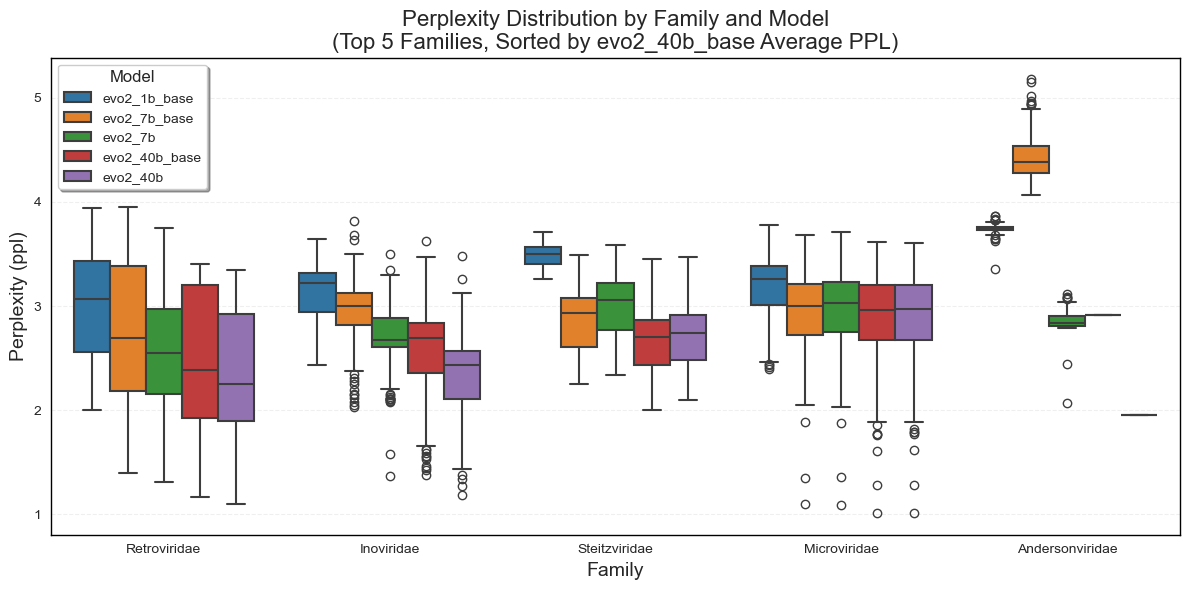


Top 5 families statistics (sorted by evo2_40b_base average ppl, smallest to largest):
  1. Retroviridae: avg_ppl=2.4947, sample_count=104
  2. Inoviridae: avg_ppl=2.5427, sample_count=226
  3. Steitzviridae: avg_ppl=2.6643, sample_count=466
  4. Microviridae: avg_ppl=2.9045, sample_count=1078
  5. Andersonviridae: avg_ppl=2.9096, sample_count=206


In [100]:
# Plot boxplot: x-axis is Family, y-axis is PPL, sorted by evo2_40b_base from smallest to largest

# 1. Calculate average ppl for each family using evo2_40b_base
family_avg_ppl = data.groupby('family')['ppl_evo2_40b_base'].mean().sort_values()

# Get top 5 families (smallest average ppl)
top5_families = family_avg_ppl.head(5).index.tolist()

print(f"Total number of families: {len(family_avg_ppl)}")
print(f"\nTop 5 families (sorted by evo2_40b_base average ppl, smallest to largest):")
for i, fam in enumerate(top5_families, 1):
    avg_ppl = family_avg_ppl[fam]
    count = len(data[data['family'] == fam])
    print(f"  {i}. {fam}: avg_ppl={avg_ppl:.4f}, sample_count={count}")

# 2. Filter data to only include top 5 families
data_top5 = data[data['family'].isin(top5_families)].copy()

# 3. Prepare data for boxplot
# Create long format data: family, model, ppl
model_columns = ['ppl_evo2_1b_base', 'ppl_evo2_7b_base', 'ppl_evo2_7b', 'ppl_evo2_40b_base', 'ppl_evo2_40b']
model_labels = ['evo2_1b_base', 'evo2_7b_base', 'evo2_7b', 'evo2_40b_base', 'evo2_40b']

plot_data = []
for _, row in data_top5.iterrows():
    family = row['family']
    for col, label in zip(model_columns, model_labels):
        if col in row and pd.notna(row[col]):
            plot_data.append({
                'family': family,
                'model': label,
                'ppl': row[col]
            })

plot_df = pd.DataFrame(plot_data)

# 4. Ensure family order is sorted by evo2_40b_base average ppl (smallest to largest)
plot_df['family'] = pd.Categorical(plot_df['family'], categories=top5_families, ordered=True)

# 5. Plot boxplot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# 设置边框为黑色
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# Use seaborn to plot grouped boxplot
import seaborn as sns

# Set colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
model_palette = {label: color for label, color in zip(model_labels, colors)}

# Plot boxplot
box_plot = sns.boxplot(
    data=plot_df,
    x='family',
    y='ppl',
    hue='model',
    palette=model_palette,
    ax=ax,
    width=0.8,
    linewidth=1.5
)

ax.set_xlabel('Family', fontsize=14)
ax.set_ylabel('Perplexity (ppl)', fontsize=14)
ax.set_title('Perplexity Distribution by Family and Model\n(Top 5 Families, Sorted by evo2_40b_base Average PPL)', fontsize=16)
ax.legend(title='Model', fontsize=10, title_fontsize=12, frameon=True, fancybox=True, shadow=True)

# Rotate x-axis labels for better display
# plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=10)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()

# 保存为330dpi的透明PNG图和PDF
save_dir = "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img"
os.makedirs(save_dir, exist_ok=True)
save_path_png = os.path.join(save_dir, "perplexity_distribution_by_family_sorted.png")
save_path_pdf = os.path.join(save_dir, "perplexity_distribution_by_family_sorted.pdf")
plt.savefig(save_path_png, dpi=330, transparent=True, bbox_inches='tight')
plt.savefig(save_path_pdf, transparent=True, bbox_inches='tight')
print(f"\n图表已保存为: {save_path_png}")
print(f"图表已保存为: {save_path_pdf}")

plt.show()

# Print statistics
print(f"\nTop 5 families statistics (sorted by evo2_40b_base average ppl, smallest to largest):")
for i, fam in enumerate(top5_families, 1):
    avg_ppl = family_avg_ppl[fam]
    count = len(data[data['family'] == fam])
    print(f"  {i}. {fam}: avg_ppl={avg_ppl:.4f}, sample_count={count}")

In [79]:
# Load all experiment results from results folder
import json
import os
from pathlib import Path

results_dir = "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results"

# List to store all results
all_results = []

# Iterate through all subdirectories in results folder
for item in os.listdir(results_dir):
    item_path = os.path.join(results_dir, item)
    
    # Skip if not a directory or if it's a CSV file
    if not os.path.isdir(item_path):
        continue
    
    config_path = os.path.join(item_path, "config.json")
    summary_path = os.path.join(item_path, "summary.json")
    
    # Check if both config.json and summary.json exist
    if not (os.path.exists(config_path) and os.path.exists(summary_path)):
        continue
    
    try:
        # Load config.json
        with open(config_path, 'r') as f:
            config = json.load(f)
        
        # Load summary.json
        with open(summary_path, 'r') as f:
            summary = json.load(f)
        
        # Extract dataset name from run_name (first part before underscore)
        run_name = config.get("run_name", "")
        if "_" in run_name:
            dataset_name = run_name.split("_")[0]
        else:
            dataset_name = run_name
        
        # Determine model type and model name
        model_type = None
        model_name = None
        
        # Check if it's an evo2 model
        if "evo2" in config:
            model_type = "evo2"
            model_name = config["evo2"].get("model_name", "unknown")
        # Check if it's a CNN model
        elif "model" in config and "type" in config["model"]:
            model_type = "CNN"
            model_name = config["model"].get("type", "unknown")
        else:
            model_type = "unknown"
            model_name = "unknown"
        
        # Extract test results from summary.json
        test_results = summary.get("test", {})
        
        # Create result record
        result = {
            "run_name": run_name,
            "dataset": dataset_name,
            "model_type": model_type,
            "model_name": model_name,
            "test_acc": test_results.get("acc", None),
            "test_mcc": test_results.get("mcc", None),
            "test_macro_f1": test_results.get("macro_f1", None),
            "test_macro_auroc_ovr": test_results.get("macro_auroc_ovr", None),
            "test_macro_aupr_ovr": test_results.get("macro_aupr_ovr", None),
            "best_val_acc": summary.get("best_val_acc", None),
            "timestamp": config.get("timestamp", ""),
            "results_dir": item_path
        }
        
        all_results.append(result)
        
    except Exception as e:
        print(f"Error processing {item_path}: {e}")
        continue

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

# Display summary
print(f"Total number of results loaded: {len(results_df)}")
print(f"\nDataset distribution:")
print(results_df['dataset'].value_counts())
print(f"\nModel type distribution:")
print(results_df['model_type'].value_counts())
print(f"\nModel name distribution:")
print(results_df['model_name'].value_counts())

# Sort by dataset, model_type, model_name, then by test_acc (descending)
results_df = results_df.sort_values(by=['dataset', 'model_type', 'model_name', 'test_acc'], ascending=[True, True, True, False]).reset_index(drop=True)

# Keep only the row with highest test_acc for each combination of dataset, model_type, model_name
# Drop rows where test_acc is NaN first, then group and keep first (which is highest due to sorting)
results_df_before_dedup = results_df.copy()
results_df = results_df.dropna(subset=['test_acc']).groupby(['dataset', 'model_type', 'model_name'], as_index=False).first()

# Reset index
results_df = results_df.reset_index(drop=True)

# Display deduplication info
print(f"\nBefore deduplication: {len(results_df_before_dedup)} rows")
print(f"After deduplication (keeping highest test_acc): {len(results_df)} rows")
print(f"Removed {len(results_df_before_dedup) - len(results_df)} duplicate rows")

# Display the DataFrame
print(f"\nResults DataFrame (sorted by dataset, model_type, model_name, keeping highest test_acc):")
results_df

Total number of results loaded: 26

Dataset distribution:
dataset
CdsCls       15
GenomeCls    11
Name: count, dtype: int64

Model type distribution:
model_type
CNN     13
evo2    13
Name: count, dtype: int64

Model name distribution:
model_name
ResCNN1D         13
evo2_1b_base      7
evo2_7b           2
evo2_40b          2
evo2_40b_base     1
evo2_7b_base      1
Name: count, dtype: int64

Before deduplication: 26 rows
After deduplication (keeping highest test_acc): 10 rows
Removed 16 duplicate rows

Results DataFrame (sorted by dataset, model_type, model_name, keeping highest test_acc):


,dataset,model_type,model_name,run_name,test_acc,test_mcc,test_macro_f1,test_macro_auroc_ovr,test_macro_aupr_ovr,best_val_acc,timestamp,results_dir
0,CdsCls,CNN,ResCNN1D,CdsCls_CNN_20251230_194512,0.680357,0.577965,0.451851,0.904139,0.522773,0.670429,2025-12-30 19:45:12,/inspire/hdd/project/aiscientist/yedongxin-CZX...
1,CdsCls,evo2,evo2_1b_base,CdsCls_Evo2MLP_20260102_045835,0.721429,0.629439,0.543157,0.918212,0.590752,0.756208,2026-01-02 04:58:36,/inspire/hdd/project/aiscientist/yedongxin-CZX...
2,CdsCls,evo2,evo2_40b,CdsCls_Evo2MLP_20260102_050232,0.744643,0.658384,0.562177,0.919658,0.592027,0.758465,2026-01-02 05:02:32,/inspire/hdd/project/aiscientist/yedongxin-CZX...
3,CdsCls,evo2,evo2_40b_base,CdsCls_Evo2MLP_20260102_050237,0.742857,0.656992,0.588533,0.916871,0.621821,0.772009,2026-01-02 05:02:37,/inspire/hdd/project/aiscientist/yedongxin-CZX...
4,CdsCls,evo2,evo2_7b,CdsCls_Evo2MLP_20260102_045842,0.714286,0.618685,0.532621,0.898906,0.546982,0.785553,2026-01-02 04:58:42,/inspire/hdd/project/aiscientist/yedongxin-CZX...
5,GenomeCls,CNN,ResCNN1D,GenomeCls_CNN_20251230_180322,0.785825,0.773584,0.497915,0.993711,0.782555,0.789182,2025-12-30 18:03:26,/inspire/hdd/project/aiscientist/yedongxin-CZX...
6,GenomeCls,evo2,evo2_1b_base,GenomeCls_Evo2MLP_20260102_045939,0.782204,0.769471,0.481363,0.992559,0.750080,0.745315,2026-01-02 04:59:44,/inspire/hdd/project/aiscientist/yedongxin-CZX...
7,GenomeCls,evo2,evo2_40b,GenomeCls_Evo2MLP_20260102_045954,0.773409,0.761670,0.515077,0.988188,0.788033,0.819421,2026-01-02 04:59:59,/inspire/hdd/project/aiscientist/yedongxin-CZX...
8,GenomeCls,evo2,evo2_7b,GenomeCls_Evo2MLP_20260102_045944,0.827212,0.817446,0.525517,0.988627,0.793630,0.816865,2026-01-02 04:59:50,/inspire/hdd/project/aiscientist/yedongxin-CZX...
9,GenomeCls,evo2,evo2_7b_base,GenomeCls_Evo2MLP_20260102_050005,0.830316,0.819961,0.529402,0.994716,0.778545,0.791738,2026-01-02 05:00:10,/inspire/hdd/project/aiscientist/yedongxin-CZX...



图表已保存为: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img/test_accuracy_comparison.png
图表已保存为: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img/test_accuracy_comparison.pdf


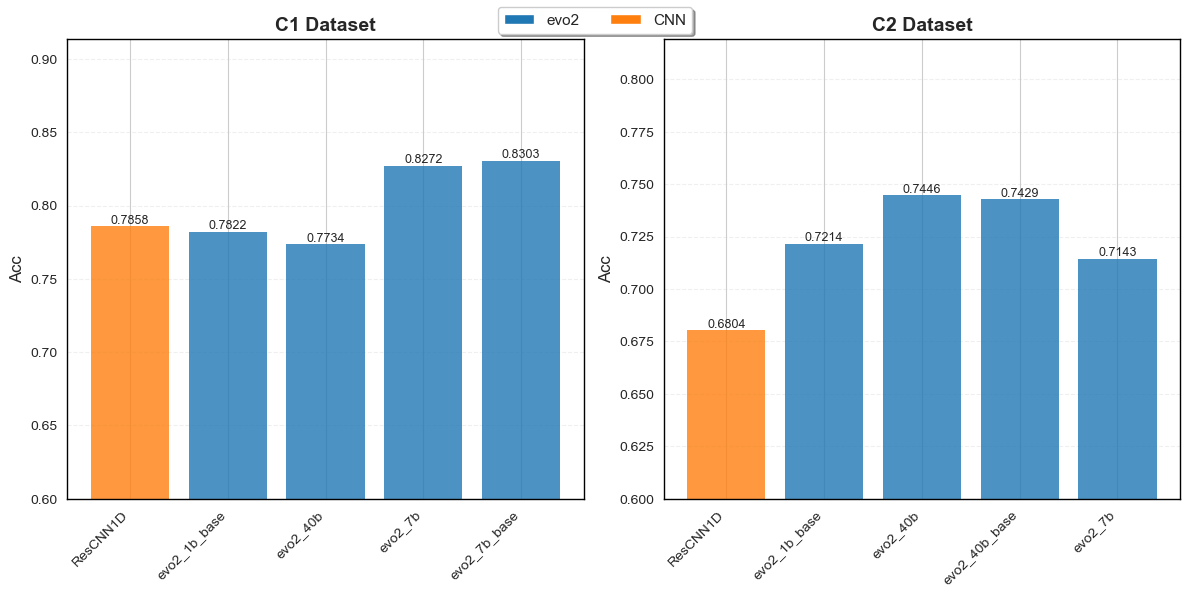


Comparison Statistics

CdsCls Dataset:
  Number of models: 5
  Best model: evo2_40b (acc=0.7446)
  Average accuracy: 0.7207
  Model types: {'evo2': 4, 'CNN': 1}

GenomeCls Dataset:
  Number of models: 5
  Best model: evo2_7b_base (acc=0.8303)
  Average accuracy: 0.7998
  Model types: {'evo2': 4, 'CNN': 1}

CdsCls Results:
   model_name model_type  test_acc  test_mcc  test_macro_f1
     ResCNN1D        CNN  0.680357  0.577965       0.451851
 evo2_1b_base       evo2  0.721429  0.629439       0.543157
     evo2_40b       evo2  0.744643  0.658384       0.562177
evo2_40b_base       evo2  0.742857  0.656992       0.588533
      evo2_7b       evo2  0.714286  0.618685       0.532621

GenomeCls Results:
  model_name model_type  test_acc  test_mcc  test_macro_f1
    ResCNN1D        CNN  0.785825  0.773584       0.497915
evo2_1b_base       evo2  0.782204  0.769471       0.481363
    evo2_40b       evo2  0.773409  0.761670       0.515077
     evo2_7b       evo2  0.827212  0.817446       0.525517


In [101]:
# Visualize results: two subplots for different datasets (CdsCls and GenomeCls)
# X-axis: model_name, Y-axis: test_acc, Bar chart

# Filter data for each dataset
cds_data = results_df[results_df['dataset'] == 'CdsCls'].copy()
genome_data = results_df[results_df['dataset'] == 'GenomeCls'].copy()

# Sort by model_name for consistent ordering
cds_data = cds_data.sort_values('model_name').reset_index(drop=True)
genome_data = genome_data.sort_values('model_name').reset_index(drop=True)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 设置边框为黑色（两个子图）
for ax in axes:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

# Define colors for different model types
color_map = {'evo2': '#1f77b4', 'CNN': '#ff7f0e'}

# Plot 1: GenomeCls (调换顺序，放在左边)
ax1 = axes[0]
if len(genome_data) > 0:
    # Create color list based on model_type
    colors_genome = [color_map.get(mt, '#9467bd') for mt in genome_data['model_type']]
    
    bars1 = ax1.bar(range(len(genome_data)), genome_data['test_acc'], color=colors_genome, alpha=0.8, edgecolor='none')
    ax1.set_xticks(range(len(genome_data)))
    ax1.set_xticklabels(genome_data['model_name'], rotation=45, ha='right', fontsize=10)
    ax1.set_ylabel('Acc', fontsize=12)
    ax1.set_title('C1 Dataset', fontsize=14, fontweight='bold')
    ax1.set_ylim([0.6, max(genome_data['test_acc'].max() * 1.1, 0.1)])
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars1, genome_data['test_acc'])):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.4f}',
                ha='center', va='bottom', fontsize=9)
else:
    ax1.text(0.5, 0.5, 'No data for GenomeCls', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('C1 Dataset', fontsize=14, fontweight='bold')

# Plot 2: CdsCls (调换顺序，放在右边)
ax2 = axes[1]
if len(cds_data) > 0:
    # Create color list based on model_type
    colors_cds = [color_map.get(mt, '#9467bd') for mt in cds_data['model_type']]
    
    bars2 = ax2.bar(range(len(cds_data)), cds_data['test_acc'], color=colors_cds, alpha=0.8, edgecolor='none')
    ax2.set_xticks(range(len(cds_data)))
    ax2.set_xticklabels(cds_data['model_name'], rotation=45, ha='right', fontsize=10)
    ax2.set_ylabel('Acc', fontsize=12)
    ax2.set_title('C2 Dataset', fontsize=14, fontweight='bold')
    ax2.set_ylim([0.6, max(cds_data['test_acc'].max() * 1.1, 0.1)])
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars2, cds_data['test_acc'])):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.4f}',
                ha='center', va='bottom', fontsize=9)
else:
    ax2.text(0.5, 0.5, 'No data for CdsCls', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('C2 Dataset', fontsize=14, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_map['evo2'], label='evo2'),
                   Patch(facecolor=color_map['CNN'], label='CNN')]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=11, frameon=True, fancybox=True, shadow=True)

plt.tight_layout()

# 保存为330dpi的透明PNG图和PDF
save_dir = "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img"
os.makedirs(save_dir, exist_ok=True)
save_path_png = os.path.join(save_dir, "test_accuracy_comparison.png")
save_path_pdf = os.path.join(save_dir, "test_accuracy_comparison.pdf")
plt.savefig(save_path_png, dpi=330, transparent=True, bbox_inches='tight')
plt.savefig(save_path_pdf, transparent=True, bbox_inches='tight')
print(f"\n图表已保存为: {save_path_png}")
print(f"图表已保存为: {save_path_pdf}")

plt.show()

# Print comparison statistics
print("\n" + "="*60)
print("Comparison Statistics")
print("="*60)

print(f"\nCdsCls Dataset:")
print(f"  Number of models: {len(cds_data)}")
if len(cds_data) > 0:
    print(f"  Best model: {cds_data.loc[cds_data['test_acc'].idxmax(), 'model_name']} (acc={cds_data['test_acc'].max():.4f})")
    print(f"  Average accuracy: {cds_data['test_acc'].mean():.4f}")
    print(f"  Model types: {cds_data['model_type'].value_counts().to_dict()}")

print(f"\nGenomeCls Dataset:")
print(f"  Number of models: {len(genome_data)}")
if len(genome_data) > 0:
    print(f"  Best model: {genome_data.loc[genome_data['test_acc'].idxmax(), 'model_name']} (acc={genome_data['test_acc'].max():.4f})")
    print(f"  Average accuracy: {genome_data['test_acc'].mean():.4f}")
    print(f"  Model types: {genome_data['model_type'].value_counts().to_dict()}")

# Display detailed data
print(f"\n{'='*60}")
print("CdsCls Results:")
print("="*60)
print(cds_data[['model_name', 'model_type', 'test_acc', 'test_mcc', 'test_macro_f1']].to_string(index=False))

print(f"\n{'='*60}")
print("GenomeCls Results:")
print("="*60)
print(genome_data[['model_name', 'model_type', 'test_acc', 'test_mcc', 'test_macro_f1']].to_string(index=False))

Confusion matrix shape: (100, 100)
Number of classes: 100
Total samples: 1933


/tmp/ipykernel_88996/3371061267.py:31: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100



图表已保存为: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img/confusion_matrix.png
图表已保存为: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img/confusion_matrix.pdf


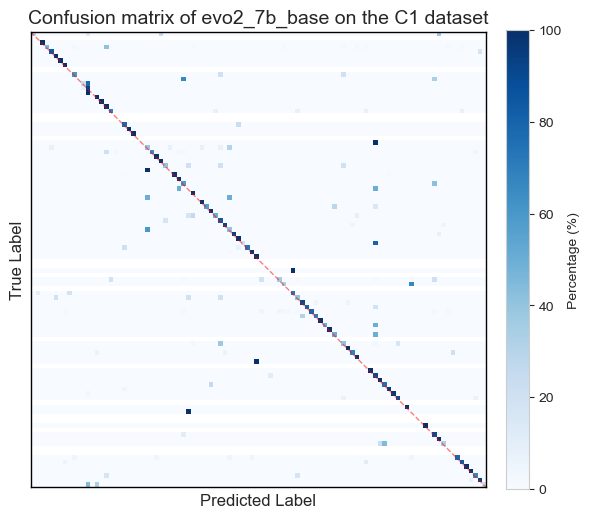

In [102]:
# Visualize confusion matrix
import json
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load test metrics and label mapping
test_metrics_path = "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/GenomeCls_Evo2MLP_20260102_050005/test_metrics.json"
label2id_path = "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/GenomeCls_Evo2MLP_20260102_050005/label2id.json"

# Load confusion matrix
with open(test_metrics_path, 'r') as f:
    test_metrics = json.load(f)

# Load label mapping
with open(label2id_path, 'r') as f:
    label2id = json.load(f)

# Create id2label mapping
id2label = {v: k for k, v in label2id.items()}

# Get confusion matrix
cm = np.array(test_metrics['confusion_matrix'])
num_classes = len(cm)

print(f"Confusion matrix shape: {cm.shape}")
print(f"Number of classes: {num_classes}")
print(f"Total samples: {cm.sum()}")

# Normalize confusion matrix (percentage)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create labels for classes (use shortened names if too long)
class_labels = [id2label[i] for i in range(num_classes)]

# Create a single figure for normalized confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# 设置边框为黑色
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# Plot normalized (percentage) confusion matrix
im = ax.imshow(cm_normalized, cmap='Blues', aspect='equal', interpolation='nearest', vmin=0, vmax=100)
ax.set_title('Confusion matrix of evo2_7b_base on the C1 dataset', fontsize=14)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Percentage (%)', fontsize=10)

# Add diagonal line for reference
ax.axline((0, 0), (num_classes-1, num_classes-1), color='red', linestyle='--', linewidth=1, alpha=0.5, label='Perfect prediction')
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()

# 保存为330dpi的透明PNG图和PDF
save_dir = "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img"
os.makedirs(save_dir, exist_ok=True)
save_path_png = os.path.join(save_dir, "confusion_matrix.png")
save_path_pdf = os.path.join(save_dir, "confusion_matrix.pdf")
plt.savefig(save_path_png, dpi=330, transparent=True, bbox_inches='tight')
plt.savefig(save_path_pdf, transparent=True, bbox_inches='tight')
print(f"\n图表已保存为: {save_path_png}")
print(f"图表已保存为: {save_path_pdf}")

plt.show()

In [6]:
data=pd.read_csv("/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/gen_cds_results_evo2_1b_base.csv")
data


,virus_idx,cds_idx,taxid,organism_name,family,genus,host_group,original_sequence,prompt_sequence,ground_truth,generated_sequence,generated_full_sequence,ground_truth_length,generated_length,exact_match_acc,edit_distance,alignment_identity,error
0,0,0,10566,Human papillomavirus,Papillomaviridae,NaN,D1,ATGGCAGACCTAACTAAAGGTACTGAACAATTTGAAACTATTGAAA...,ATGGCAGACCTAACTAAAGGTACTGAACAATTTGAAACTATTGAAA...,AGATGGTTCTGTTATTTCTGAATTGATTGATGATGTGGATAATGCT...,TGAATATGAAGGTAAACCAAGTGTAATTATTATAAGTTCAATTTGG...,TGAATATGAAGGTAAACCAAGTGTAATTATTATAAGTTCAATTTGG...,1675,1675,0.326567,0.489552,0.151642,NaN
1,0,1,10566,Human papillomavirus,Papillomaviridae,NaN,D1,ATGACTCTGTGGATGCAACATTCTGGAAAATTATACCTACCACCAG...,ATGACTCTGTGGATGCAACATTCTGGAAAATTATACCTACCACCAG...,ATTAACGGTTGGACACCCTTACTTTGAAATTCCAAATCAGGCTATA...,TCTGTAATAATGTCTGCTGTGGTGTACTTGTAATGTGCCCTTTGGG...,TCTGTAATAATGTCTGCTGTGGTGTACTTGTAATGTGCCCTTTGGG...,1540,1540,0.246104,0.518831,0.105844,NaN
2,0,2,10566,Human papillomavirus,Papillomaviridae,NaN,D1,ATGTATAGAACAAAAAGAGTAAAGCGTGATACTGTTGAAAATATCT...,ATGTATAGAACAAAAAGAGTAAAGCGTGATACTGTTGAAAATATCT...,AAAAATATTTGGAAGTGTAATTTATTTGGGTGGATTGGGAATTGGC...,TTCTTACGCTAATAAGCTAATAAATTCCCCTGATAGTTCTACCCTT...,TTCTTACGCTAATAAGCTAATAAATTCCCCTGATAGTTCTACCCTT...,1432,1432,0.270251,0.509078,0.125000,NaN
3,1,0,10571,Bovine papillomavirus,Papillomaviridae,NaN,D2,ATGGCCGAAAATAAAGGTACTTTGGGAGATGGAGATTGGTATTTTG...,ATGGCCGAAAATAAAGGTACTTTGGGAGATGGAGATTGGTATTTTG...,CAATGCACAAGTTAGTCAGGGCAACTCCCTCCAGTTGTTCCAGGAG...,AGAACCCAGTGACACAAAGACTTATAGTCGTTTGTCTCCTATTAGA...,AGAACCCAGTGACACAAAGACTTATAGTCGTTTGTCTCCTATTAGA...,1720,1720,0.286628,0.518605,0.096512,NaN
4,1,1,10571,Bovine papillomavirus,Papillomaviridae,NaN,D2,ATGTCTCGCAGACGCAAAAGAGATACTGTGCAAAACATCTATAACA...,ATGTCTCGCAGACGCAAAAGAGATACTGTGCAAAACATCTATAACA...,TGGCTCTGGATTGGTTTACTTTGGAAATGCAGGCATTGGGACAGGG...,TAGTCATTTGCATGACTCCCTATTCATCAACTTCGTCATAGTGCTT...,TAGTCATTTGCATGACTCCCTATTCATCAACTTCGTCATAGTGCTT...,1417,1417,0.247706,0.527170,0.083980,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017,2924,0,2950472,Vibrio phage vB_VpaP_M9,Autoscriptoviridae,Maculvirus,A,ATGGCTATTTTTGAGAACCGTCGCCCATCTTCACAGGGTGCTGGCT...,ATGGCTATTTTTGAGAACCGTCGCCCATCTTCACAGGGTGCTGGCT...,GTGAGAAGCACGGCGTTAACACATTCGACATGTTCTTTAACCGCGC...,GTGGCGGTAACGAATCTAACCTTGACCCAGCCACAGCTAAAAGTTT...,GTGGCGGTAACGAATCTAACCTTGACCCAGCCACAGCTAAAAGTTT...,1928,1928,0.265041,0.508299,0.134855,NaN
3018,2925,0,2950728,Escherichia phage W115,Straboviridae,Krischvirus,A,ATGGCAGATTTTTCTCAACATTTCAAGGCCACATTTGGCTTTGACG...,ATGGCAGATTTTTCTCAACATTTCAAGGCCACATTTGGCTTTGACG...,CCCCGCAAGATGCTTTACTAATCACGACTCGCACGCTAACGAAACG...,ACTTCTTGGATCATGTGATCGTTACGCCAAAAGCTTTGAATACCCA...,ACTTCTTGGATCATGTGATCGTTACGCCAAAAGCTTTGAATACCCA...,1871,1871,0.279530,0.514698,0.124532,NaN
3019,2926,0,2950735,Ixodes ricinus noda-like-virus 1,Nodaviridae,NaN,E,ATGTCTATGTCTATAAACTCGCTTAGTGAGGTGAGGTGCACTCCCT...,ATGTCTATGTCTATAAACTCGCTTAGTGAGGTGAGGTGCACTCCCT...,CAAGTGGATCCCAACCAGTCCGGTGCTTCATTCAGATACATCGGGG...,GTCGCTTTGCCGAGGAAGACCGCCGTTCGTAATGGCATTAGTGAGA...,GTCGCTTTGCCGAGGAAGACCGCCGTTCGTAATGGCATTAGTGAGA...,987,987,0.249240,0.530902,0.088146,NaN
3020,2927,0,2950737,Ixodes ricinus picorna-like virus 1,Picornaviridae,NaN,E,ATGGTTACAATTAACGAGAAAAACGAAATCTGCGAAGTGGTAGCCC...,ATGGTTACAATTAACGAGAAAAACGAAATCTGCGAAGTGGTAGCCC...,CCAAACTATGTGGGTTCCTATGAACAATATTGTATCTTAAAAGAAC...,CGGTATTTTGTAGCTTTCGATTCATGTGATGTAACTCCTGAGTCAC...,CGGTATTTTGTAGCTTTCGATTCATGTGATGTAACTCCTGAGTCAC...,4620,4620,0.279004,0.514719,0.111255,NaN


In [18]:
# 翻译DNA序列为蛋白质
def translate_dna_to_protein(dna_seq):
    """将DNA序列翻译为蛋白质序列"""
    if pd.isna(dna_seq) or not dna_seq or str(dna_seq).strip() == '':
        return None
    try:
        seq = Seq(str(dna_seq).upper())
        protein = seq.translate(to_stop=True)  # to_stop=False保留终止密码子
        return str(protein)
    except Exception:
        # 如果产生错误则忽略该行，返回None
        return None

# 添加original_protein列（带进度条）
print("Translating original_sequence to original_protein...")
data['original_protein'] = [translate_dna_to_protein(seq) for seq in tqdm(data['original_sequence'], desc="Original sequences")]

# 拼接prompt_sequence和generated_sequence，然后翻译为蛋白质
def combine_and_translate(row):
    try:
        prompt = str(row['prompt_sequence']) if pd.notna(row['prompt_sequence']) else ''
        generated = str(row['generated_sequence']) if pd.notna(row['generated_sequence']) else ''
        combined = prompt + generated
        return translate_dna_to_protein(combined)
    except Exception:
        # 如果产生错误则忽略该行，返回None
        return None

print("\nTranslating prompt_sequence+generated_sequence to generated_protein...")
data['generated_protein'] = [combine_and_translate(row) for _, row in tqdm(data.iterrows(), total=len(data), desc="Generated sequences")]

# 显示结果
print(f"Total rows: {len(data)}")
print(f"Original protein non-null: {data['original_protein'].notna().sum()}")
print(f"Generated protein non-null: {data['generated_protein'].notna().sum()}")
data[['original_sequence', 'original_protein', 'prompt_sequence', 'generated_sequence', 'generated_protein']].head()


Translating original_sequence to original_protein...


Original sequences: 100%|██████████| 3022/3022 [00:00<00:00, 6554.94it/s]



Translating prompt_sequence+generated_sequence to generated_protein...


Generated sequences: 100%|██████████| 3022/3022 [00:00<00:00, 7274.91it/s]

Total rows: 3022
Original protein non-null: 3022
Generated protein non-null: 3019


,original_sequence,original_protein,prompt_sequence,generated_sequence,generated_protein
0,ATGGCAGACCTAACTAAAGGTACTGAACAATTTGAAACTATTGAAA...,MADLTKGTEQFETIEKDDSWYIVSEAECITDLNSLDNIFEESTDGS...,ATGGCAGACCTAACTAAAGGTACTGAACAATTTGAAACTATTGAAA...,TGAATATGAAGGTAAACCAAGTGTAATTATTATAAGTTCAATTTGG...,MADLTKGTEQFETIEKDDSWYIVSEAECITDLNSLDNIFEESTEYE...
1,ATGACTCTGTGGATGCAACATTCTGGAAAATTATACCTACCACCAG...,MTLWMQHSGKLYLPPAKPVAKVLNTDDYVVGTNLFFHASSERLLTV...,ATGACTCTGTGGATGCAACATTCTGGAAAATTATACCTACCACCAG...,TCTGTAATAATGTCTGCTGTGGTGTACTTGTAATGTGCCCTTTGGG...,MTLWMQHSGKLYLPPAKPVAKVLNTDDYVVGTNLFFHASSERFL
2,ATGTATAGAACAAAAAGAGTAAAGCGTGATACTGTTGAAAATATCT...,MYRTKRVKRDTVENIYQQCKISGNCPPDVVNKVEQTTLADLLLKIF...,ATGTATAGAACAAAAAGAGTAAAGCGTGATACTGTTGAAAATATCT...,TTCTTACGCTAATAAGCTAATAAATTCCCCTGATAGTTCTACCCTT...,MYRTKRVKRDTVENIYQQCKISGNCPPDVVNKVEQTTLADLLFSYA...
3,ATGGCCGAAAATAAAGGTACTTTGGGAGATGGAGATTGGTATTTTG...,MAENKGTLGDGDWYFVREAECSDIDSIEELELSTESEVSDLIDNAQ...,ATGGCCGAAAATAAAGGTACTTTGGGAGATGGAGATTGGTATTTTG...,AGAACCCAGTGACACAAAGACTTATAGTCGTTTGTCTCCTATTAGA...,MAENKGTLGDGDWYFVREAECSDIDSIEELELSTESEVSDLIEEPS...
4,ATGTCTCGCAGACGCAAAAGAGATACTGTGCAAAACATCTATAACA...,MSRRRKRDTVQNIYNTCKIWGNCPDDVINKVESSTIADKILKYGSG...,ATGTCTCGCAGACGCAAAAGAGATACTGTGCAAAACATCTATAACA...,TAGTCATTTGCATGACTCCCTATTCATCAACTTCGTCATAGTGCTT...,MSRRRKRDTVQNIYNTCKIWGNCPDDVINKVESSTIADKILKYSHL...


In [20]:
# 找到所有original_protein长度等于generated_protein长度的行
equal_length_rows = data[data['original_protein'].str.len() == data['generated_protein'].str.len()]

equal_length_rows

,virus_idx,cds_idx,taxid,organism_name,family,genus,host_group,original_sequence,prompt_sequence,ground_truth,generated_sequence,generated_full_sequence,ground_truth_length,generated_length,exact_match_acc,edit_distance,alignment_identity,error,original_protein,generated_protein
2161,2001,0,2822897,Sclerotinia sclerotiorum narnavirus 1,Narnaviridae,Narnavirus,B,ATGTCAAATTTTGAAATAAATCAAAAACTTACACATGATAGTAGGG...,ATGTCAAATTTTGAAATAAATCAAAAACTTACACATGATAGTAGGG...,TGGGCAGAAGCTGAACGTAGTCAGGGACACCGGTACGATTTCGTAT...,TGCGTGGCCCGTCGTGCTGTGCAGAAACTTAACTCGATGTTTTCGA...,TGCGTGGCCCGTCGTGCTGTGCAGAAACTTAACTCGATGTTTTCGA...,1236,1236,0.264563,0.525081,0.103560,NaN,MSNFEINQKLTHDSRVYAEMANFLLWFDRSRPPMSNPEALDPYVTG...,MSNFEINQKLTHDSRVYAEMANFLLWFDRSRPPMSNPEALDPYVTG...
2233,2080,0,2843865,Bovine faeces associated smacovirus 1,Smacoviridae,Bonzesmacovirus,D2,ATGCCCACTGTCCATATATCCGAGACGTTTGACCTTTCCACCAAGG...,ATGCCCACTGTCCATATATCCGAGACGTTTGACCTTTCCACCAAGG...,CGTCCTCTCATGTATCCTCTCCTGTCTGACATCGGTAATGACATCA...,AAGGATGGTATTACCTTCCCCGAGGGTTCCACCGTCGAGTGGAAGT...,AAGGATGGTATTACCTTCCCCGAGGGTTCCACCGTCGAGTGGAAGT...,477,477,0.259958,0.515723,0.123690,NaN,MPTVHISETFDLSTKAGKLGLIGIHTPPRSLVELHYGPLMSNYRKI...,MPTVHISETFDLSTKAGKLGLIGIHTPPRSLVELHYGPLMSNYRKI...
2488,2337,0,2851144,Microvirus mar12,Microviridae,NaN,D3,ATGAAACGCAGACAAAGTGATTCTTTTAACCTCGCGCCGCTTCTTC...,ATGAAACGCAGACAAAGTGATTCTTTTAACCTCGCGCCGCTTCTTC...,GGACTGTTGTAAAAAATTCTATTGAGGGTGATGTTCCTTATTCTAC...,GTGTTGGTCCAAATTATCTTCCTATCGACTTTTTCAAGTGCATTCC...,GTGTTGGTCCAAATTATCTTCCTATCGACTTTTTCAAGTGCATTCC...,878,878,0.302961,0.514806,0.127563,NaN,MKRRQSDSFNLAPLLRRKRTVFPQDSSLLTTFDTGKLIPLCVKEIY...,MKRRQSDSFNLAPLLRRKRTVFPQDSSLLTTFDTGKLIPLCVKEIY...
2554,2403,0,2853105,Genomovirus AZ4_17,Genomoviridae,NaN,D1,ATGGTGAAAAAGTTCAAACTCGAAGATGTCAACTTTTGCTTCCTCA...,ATGGTGAAAAAGTTCAAACTCGAAGATGTCAACTTTTGCTTCCTCA...,GACCACTACCGGCAGGATGCGGCCGAATACGTCTCACCGGAAGGTA...,TTGTTCCATGGAATTGGTGACAGTCTCAAGACAGCACTGTTATGGT...,TTGTTCCATGGAATTGGTGACAGTCTCAAGACAGCACTGTTATGGT...,504,504,0.271825,0.500000,0.138889,NaN,MVKKFKLEDVNFCFLTYSNCPLDFDPQLIIDAVTGAGAVYRLGREE...,MVKKFKLEDVNFCFLTYSNCPLDFDPQLIIDAVTGAGAVYRLGREE...
2761,2652,0,2910785,Salmonella phage PhiSTP1,Sarkviridae,Cornellvirus,A,ATGACTAATTTTATTCGCAGACCTTATCAAAAACTAATAACTGCGC...,ATGACTAATTTTATTCGCAGACCTTATCAAAAACTAATAACTGCGC...,GTCGCATCCGGCACCTGGCCGGCAGAACAGGTGAAATGGCAGTTCC...,GAAGTGGGCAAGGCCATCGCGGCGGAGCTGCGGCGCGCGCTCGGCC...,GAAGTGGGCAAGGCCATCGCGGCGGAGCTGCGGCGCGCGCTCGGCC...,1245,1245,0.301205,0.502811,0.142169,NaN,MTNFIRRPYQKLITAHIMKHPRANVFATMGSGKCLKINTKIIMFDG...,MTNFIRRPYQKLITAHIMKHPRANVFATMGSGKCLKINTKIIMFDG...
2920,2826,0,2929377,Peromfec virus RodF8_46,Microviridae,NaN,D3,ATGAGTTGTGAACAGCCGCTTAAAGGTTATTGGAGTAAAAAAAAAC...,ATGAGTTGTGAACAGCCGCTTAAAGGTTATTGGAGTAAAAAAAAAC...,TTATTACTGATTTATGGGGCAAAGGTCTTGTTACTATTGGTAGCTT...,ATTTTGTTAATAAATTGTTTGATGTTATTAAGCTTAATCCTGTTGA...,ATTTTGTTAATAAATTGTTTGATGTTATTAAGCTTAATCCTGTTGA...,473,473,0.310782,0.505285,0.122622,NaN,MSCEQPLKGYWSKKKHPSTGRRYVVFNPSEGFVDRPVYVPCGKCIL...,MSCEQPLKGYWSKKKHPSTGRRYVVFNPSEGFVDRPVYVPCGKCIL...


In [17]:
data[["taxid","host_group","original_protein","generated_protein"]].to_csv("/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/gen_cds_results_evo2_1b_base_protein.csv",index=False)

In [ ]:
# 在此处编写加载evo2的模型测试结果可视化，横坐标为序列长度，两个纵坐标，一个为用时，一个为使用的显存大小
# 数据来自/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/max_length_stream_20260101_231445.jsonl文件
# 数据示例为
{"type": "config", "timestamp": "2026-01-01T23:14:45", "model": "evo2_40b", "config": {"start_length": 1024, "max_length": 1000000, "step_size": 1024, "prompt_length": 512, "temperature": 1.0, "top_k": 4, "seed": 42}, "prompt_seq": "GACAGGTACAAGAAGGAGTATGCATCAATGTGGTCGTGTGGAACAAACGCCACTGGAGACTGGGTTAACCATTCGCTCCAGCGTCATGAAAGTCACTGTTAGGGCGACCTTCGATTCGGATGTGACATTTCATTACATTACGCTCAGGACTGCGAACGAAAGATTAAGAATGCTTAACCCGGTACCTAACCCATCTGATTTTTACACACTCTCCTTGGACTGGGAGGTATAAGGAATAGGCGGTAGACGCCTACTTAACTTTCATGGTGATCGTAAAGCGGAGCCTTACCATGCGGCAATTGTGAACTTTTAAATTCGATTTTTAGCTTTTCTATTATCCTAAACTTCGCTGTATATCACGCGGCGCGATGGGGCAGCCTGCCCCCACTGTGCGACCGGCCACTTAAGGCTTGAAAACTACGAGCAGATTACATGAATCTGTGTTGGGTGTGCCAGTGGCACCCGAAGGACGCACTGGTTCACTTTCGGGAACACGCACAGACGAGACACAC", "initial_memory": {"allocated_mb": 78432.634765625, "reserved_mb": 91950.0, "max_allocated_mb": 81504.6376953125, "available": true}}
{"type": "result", "timestamp": "2026-01-01T23:15:19", "max_successful_length_so_far": 1024, "length": 1024, "status": "success", "time": 33.9431049823761, "actual_length": 1024, "memory": {"baseline_memory_mb": 78432.634765625, "peak_allocated_mb": 83571.88916015625, "memory_used_mb": 5139.25439453125, "reserved_mb": 95046.0}}
{"type": "result", "timestamp": "2026-01-01T23:16:22", "max_successful_length_so_far": 2048, "length": 2048, "status": "success", "time": 63.15442395210266, "actual_length": 2048, "memory": {"baseline_memory_mb": 78501.689453125, "peak_allocated_mb": 83802.02197265625, "memory_used_mb": 5300.33251953125, "reserved_mb": 95048.0}}
{"type": "result", "timestamp": "2026-01-01T23:17:57", "max_successful_length_so_far": 3072, "length": 3072, "status": "success", "time": 94.83504343032837, "actual_length": 3072, "memory": {"baseline_memory_mb": 78505.689453125, "peak_allocated_mb": 84032.02978515625, "memory_used_mb": 5526.34033203125, "reserved_mb": 95050.0}}



Figure saved to: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img/evo2_model_test_results.png
Figure saved to: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img/evo2_model_test_results.pdf


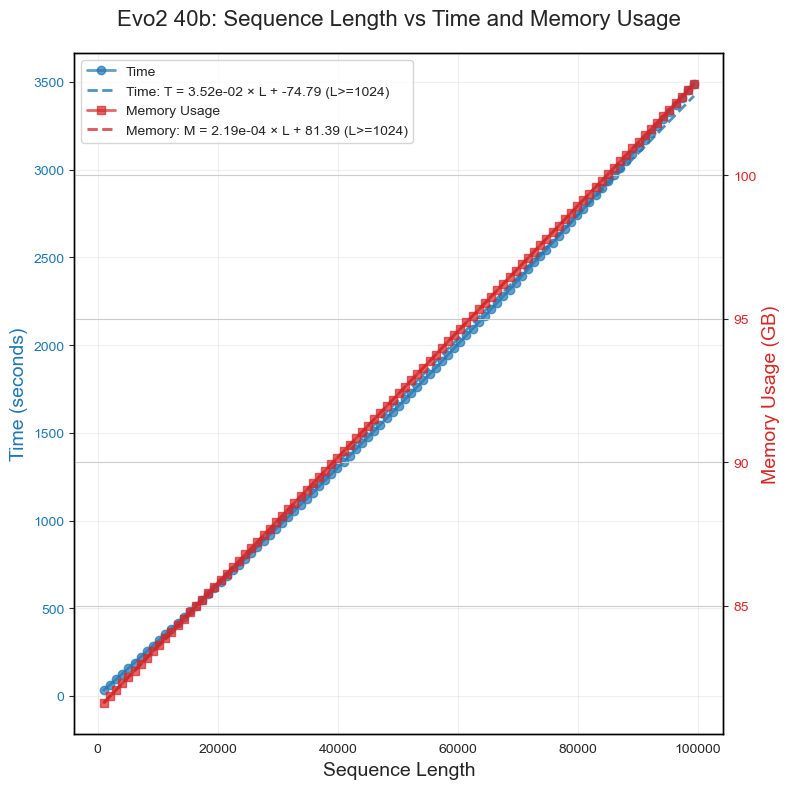

Number of data points: 97
Sequence length range: 1024 - 99328
Time range: 33.94 - 3489.52 seconds
Memory usage range: 81.61 - 103.18 GB

Linear Regression Results

Time vs Sequence Length:
  Formula: Time = 3.519047e-02 * Length + -74.7913
  R² Score: 0.998961
  Interpretation: Time increases by 3.519047e-02 seconds per base pair

Memory Usage vs Sequence Length:
  Formula: Memory (GB) = 2.193465e-04 * Length + 81.3909
  R² Score: 1.000000
  Interpretation: Memory increases by 2.193465e-04 GB per base pair


In [103]:

# Set plot style
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (6, 6)

# Load evo2 model test results visualization
# Data from /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/max_length_stream_20260101_231445.jsonl file
data_file = "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/max_length_stream_20260101_231445.jsonl"

# Read and parse JSONL file
lengths = []
times = []
memory_used_gb = []

with open(data_file, 'r') as f:
    for line in f:
        data = json.loads(line.strip())
        if data.get('type') == 'result' and data.get('status') == 'success':
            lengths.append(data['length'])
            times.append(data['time'])
            # Convert MB to GB (divide by 1024)
            peak_allocated_mb = data['memory']['peak_allocated_mb']
            memory_used_gb.append(peak_allocated_mb / 1024.0)

# Convert to numpy arrays for regression
lengths_array = np.array(lengths)
times_array = np.array(times)
memory_array = np.array(memory_used_gb)

# Linear regression for Time vs Length
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Reshape for sklearn
X = lengths_array.reshape(-1, 1)

# Fit linear regression for Time
reg_time = LinearRegression()
reg_time.fit(X, times_array)
time_pred = reg_time.predict(X)
time_r2 = r2_score(times_array, time_pred)
time_slope = reg_time.coef_[0]
time_intercept = reg_time.intercept_

# Fit linear regression for Memory
reg_memory = LinearRegression()
reg_memory.fit(X, memory_array)
memory_pred = reg_memory.predict(X)
memory_r2 = r2_score(memory_array, memory_pred)
memory_slope = reg_memory.coef_[0]
memory_intercept = reg_memory.intercept_

# Create dual y-axis plot
fig, ax1 = plt.subplots(figsize=(8, 8))

# 设置边框为黑色（主y轴）
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# Format formulas with 2 decimal places
time_formula = f"T = {time_slope:.2e} × L + {time_intercept:.2f} (L>=1024)"
memory_formula = f"M = {memory_slope:.2e} × L + {memory_intercept:.2f} (L>=1024)"

# Left y-axis: Time
color1 = 'tab:blue'
ax1.set_xlabel('Sequence Length', fontsize=14)
ax1.set_ylabel('Time (seconds)', color=color1, fontsize=14)
line1 = ax1.plot(lengths, times, color=color1, marker='o', linewidth=2, markersize=6, label='Time', alpha=0.7)
# Plot regression line for Time with formula in label
reg_line1 = ax1.plot(lengths_array, time_pred, color=color1, linestyle='--', linewidth=2, label=f'Time: {time_formula}', alpha=0.8)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Right y-axis: Memory usage
ax2 = ax1.twinx()

# 设置边框为黑色（第二个y轴）
for spine in ax2.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

color2 = 'tab:red'
ax2.set_ylabel('Memory Usage (GB)', color=color2, fontsize=14)
line2 = ax2.plot(lengths, memory_used_gb, color=color2, marker='s', linewidth=2, markersize=6, label='Memory Usage', alpha=0.7)
# Plot regression line for Memory with formula in label
reg_line2 = ax2.plot(lengths_array, memory_pred, color=color2, linestyle='--', linewidth=2, label=f'Memory: {memory_formula}', alpha=0.8)
ax2.tick_params(axis='y', labelcolor=color2)

# Add legend - combine all lines
all_lines = line1 + reg_line1 + line2 + reg_line2
all_labels = [l.get_label() for l in all_lines]
ax1.legend(all_lines, all_labels, loc='upper left', fontsize=10)

# Set title
plt.title('Evo2 40b: Sequence Length vs Time and Memory Usage', fontsize=16, pad=20)

# Adjust layout
fig.tight_layout()

# Save figure as transparent PNG and PDF
save_dir = "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/results/img"
os.makedirs(save_dir, exist_ok=True)
save_path_png = os.path.join(save_dir, "evo2_model_test_results.png")
save_path_pdf = os.path.join(save_dir, "evo2_model_test_results.pdf")
fig.savefig(save_path_png, dpi=300, transparent=True, bbox_inches='tight')
fig.savefig(save_path_pdf, transparent=True, bbox_inches='tight')
print(f"\nFigure saved to: {save_path_png}")
print(f"Figure saved to: {save_path_pdf}")

plt.show()

# Print statistics
print(f"Number of data points: {len(lengths)}")
print(f"Sequence length range: {min(lengths)} - {max(lengths)}")
print(f"Time range: {min(times):.2f} - {max(times):.2f} seconds")
print(f"Memory usage range: {min(memory_used_gb):.2f} - {max(memory_used_gb):.2f} GB")

# Print regression formulas
print("\n" + "="*60)
print("Linear Regression Results")
print("="*60)
print(f"\nTime vs Sequence Length:")
print(f"  Formula: Time = {time_slope:.6e} * Length + {time_intercept:.4f}")
print(f"  R² Score: {time_r2:.6f}")
print(f"  Interpretation: Time increases by {time_slope:.6e} seconds per base pair")

print(f"\nMemory Usage vs Sequence Length:")
print(f"  Formula: Memory (GB) = {memory_slope:.6e} * Length + {memory_intercept:.4f}")
print(f"  R² Score: {memory_r2:.6f}")
print(f"  Interpretation: Memory increases by {memory_slope:.6e} GB per base pair")
print("="*60)
